<a href="https://colab.research.google.com/github/cjvilla/enose_predictions/blob/main/exploratory_data.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Import Modules**

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt  # Import Matplotlib for plotting

from fpdf import FPDF

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score

import seaborn as sns
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, confusion_matrix

from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
raw_data = pd.read_csv('../content/drive/MyDrive/eNose/sensor_data.csv')

In [3]:
raw_data.columns

Index(['S1', 'S2', 'S3', 'S4', 'S5', 'S6', 'S7', 'S8', 'S9', 'S10', 'S11',
       'S12', 'S13', 'S14', 'S15', 'S16', 'S17', 'S18', 'S19', 'S20', 'S21',
       'S22', 'S23', 'S24', 'S25', 'S26', 'S27', 'S28', 'S29', 'S30', 'S31',
       'S32', 'real_idn', 'group'],
      dtype='object')

In [4]:
raw_data.head()

,S1,S2,S3,S4,S5,S6,S7,S8,S9,S10,...,S25,S26,S27,S28,S29,S30,S31,S32,real_idn,group
0,3.835712,4.669524,1.461880,4.352212,0.756478,0.677005,0.943742,3.161918,0.821758,1.174492,...,1.842636,2.643683,0.889705,4.263684,1.913926,2.114062,1.198792,1.094935,MMA045,0
1,3.847488,4.682320,1.464670,4.361580,0.768324,0.679536,0.944552,3.163610,0.823867,1.175820,...,1.846072,2.656102,0.890494,4.285047,1.919609,2.118205,1.478009,1.096809,MMA045,0
2,3.855080,4.691066,1.466731,4.369564,0.781708,0.681342,0.945130,3.165088,0.825759,1.177301,...,1.847187,2.660622,0.890642,4.292239,1.921933,2.119541,1.853633,1.097373,MMA045,0
3,3.857629,4.693313,1.467464,4.371394,0.787963,0.682066,0.945326,3.164504,0.826536,1.177779,...,1.847731,2.662404,0.890850,4.295034,1.923496,2.120260,1.925800,1.097589,MMA045,0
4,3.859445,4.694914,1.467881,4.372620,0.792092,0.682402,0.945419,3.164910,0.826925,1.178111,...,1.848137,2.663836,0.890928,4.297929,1.924176,2.120752,1.935807,1.097782,MMA045,0


# Functions

In [5]:
demographics = pd.read_csv("/content/drive/MyDrive/eNose/demographics.csv")

In [6]:
# Define a function to map values in the 'Sex' column to 'Sex_Description'
def map_sex_to_description(sex_value):
    if sex_value == 1:
        return 'Female'
    elif sex_value == 2:
        return 'Male'
    else:
        return 'Unknown'  # You can specify a default value for other cases if needed

# Update the 'Sex_Description' column based on the 'Sex' column
demographics['Sex_Description'] = np.vectorize(map_sex_to_description)(demographics['Sex'])


In [7]:
# Define a function to map values in the 'Race' column to 'Race_Description'
def map_race_to_description(race_value):
    if race_value == 1:
        return 'Asian'
    elif race_value == 2:
        return 'Black'
    elif race_value == 3:
        return 'Hispanic'
    elif race_value == 4:
        return 'White'
    else:
        return 'Unknown'  # You can specify a default value for other cases if needed

# Apply the mapping function to create the new column
demographics['Race_Description'] = np.vectorize(map_race_to_description)(demographics['Race'])


In [8]:
# Define a function to map values in the 'Group' column to 'Group_Diagnosis'
def map_group_to_diagnosis(group_value):
    if group_value == 0:
        return 'Healthy Control'
    elif group_value == 1:
        return 'Alcoholic Liver Disease'
    elif group_value == 2:
        return "Parkinson's"
    else:
        return 'Unknown'  # You can specify a default value for other cases if needed

# Apply the mapping function to create the new column
demographics['Group_Diagnosis'] = np.vectorize(map_group_to_diagnosis)(demographics['group'])


In [9]:
def dataframe_to_pdf(dataframe, name, output_path):
    # Set the pandas options to display all rows and columns without truncation
    pd.set_option('display.max_rows', None)
    pd.set_option('display.max_columns', None)

    # Convert DataFrame to HTML
    dataframe_html = dataframe.to_html()

    # Create PDF
    class PDF(FPDF):
        def header(self):
            self.set_font('Arial', 'B', 12)
            self.cell(0, 10, f'{name} Data', 0, 1, 'C')

        def footer(self):
            self.set_y(-15)
            self.set_font('Arial', 'I', 8)
            self.cell(0, 10, f'Page {self.page_no()}', 0, 0, 'C')

    pdf = PDF()
    pdf.add_page()
    pdf.set_auto_page_break(auto=True, margin=15)
    pdf.set_font('Arial', '', 12)
    pdf.multi_cell(0, 10, dataframe_html)

    # Save the PDF
    pdf.output(output_path)

# **ETL/Data Cleaning**

In [10]:
# Define the desired column order
desired_column_order = [
    'real_idn', 'Age', 'Sex', 'Sex_Description', 'Race', 'Race_Description', 'BMI',
    'LPS_Endotoxin', 'Perm_sucralose', 'group', 'Group_Diagnosis', 'S1_mean', 'S2_mean',
    'S3_mean', 'S4_mean', 'S5_mean', 'S6_mean', 'S7_mean', 'S8_mean', 'S9_mean',
    'S10_mean', 'S11_mean', 'S12_mean', 'S13_mean', 'S14_mean', 'S15_mean', 'S16_mean',
    'S17_mean', 'S18_mean', 'S19_mean', 'S20_mean', 'S21_mean', 'S22_mean', 'S23_mean',
    'S24_mean', 'S25_mean', 'S26_mean', 'S27_mean', 'S28_mean', 'S29_mean', 'S30_mean',
    'S31_mean', 'S32_mean'
]

# Reorder the columns
demographics = demographics[desired_column_order]


In [11]:
# merging the demographic data columns with sensors of the raw data
demographics = pd.merge(demographics, raw_data, on=['group', 'real_idn'], how='inner')

In [12]:
demographics.head()

,real_idn,Age,Sex,Sex_Description,Race,Race_Description,BMI,LPS_Endotoxin,Perm_sucralose,group,...,S23,S24,S25,S26,S27,S28,S29,S30,S31,S32
0,ALD018,63,1,Female,4,White,0.0,1.56,2.934,1,...,2.356016,6.294104,1.838590,2.647479,0.886560,4.246110,1.905445,2.117732,1.201969,1.088031
1,ALD018,63,1,Female,4,White,0.0,1.56,2.934,1,...,2.361753,6.295189,1.839867,2.652587,0.886847,4.255427,1.909048,2.120294,1.285836,1.089582
2,ALD018,63,1,Female,4,White,0.0,1.56,2.934,1,...,2.377445,6.297019,1.841285,2.658237,0.887237,4.264815,1.911653,2.122250,1.540931,1.090433
3,ALD018,63,1,Female,4,White,0.0,1.56,2.934,1,...,2.384762,6.298600,1.842100,2.661015,0.887396,4.269175,1.912794,2.123079,1.656784,1.090749
4,ALD018,63,1,Female,4,White,0.0,1.56,2.934,1,...,2.389403,6.297993,1.842561,2.662513,0.887452,4.272082,1.913618,2.123772,1.708785,1.090944


In [13]:
# Get a list of columns to drop based on the condition
columns_to_drop = [col for col in demographics.columns if '_mean' in col]

# Drop the columns from the DataFrame
demographics = demographics.drop(columns=columns_to_drop)

#### csv output

In [14]:
# csv format
demographics.to_csv('/content/drive/MyDrive/eNose/Outputs/csv_format/demographics.csv')
demographics.to_html('/content/drive/MyDrive/eNose/Outputs/pdf_format/demographics.pdf')

### pdf format

In [15]:
demographics.head()

,real_idn,Age,Sex,Sex_Description,Race,Race_Description,BMI,LPS_Endotoxin,Perm_sucralose,group,...,S23,S24,S25,S26,S27,S28,S29,S30,S31,S32
0,ALD018,63,1,Female,4,White,0.0,1.56,2.934,1,...,2.356016,6.294104,1.838590,2.647479,0.886560,4.246110,1.905445,2.117732,1.201969,1.088031
1,ALD018,63,1,Female,4,White,0.0,1.56,2.934,1,...,2.361753,6.295189,1.839867,2.652587,0.886847,4.255427,1.909048,2.120294,1.285836,1.089582
2,ALD018,63,1,Female,4,White,0.0,1.56,2.934,1,...,2.377445,6.297019,1.841285,2.658237,0.887237,4.264815,1.911653,2.122250,1.540931,1.090433
3,ALD018,63,1,Female,4,White,0.0,1.56,2.934,1,...,2.384762,6.298600,1.842100,2.661015,0.887396,4.269175,1.912794,2.123079,1.656784,1.090749
4,ALD018,63,1,Female,4,White,0.0,1.56,2.934,1,...,2.389403,6.297993,1.842561,2.662513,0.887452,4.272082,1.913618,2.123772,1.708785,1.090944


# **Testing and Training**

##  Temporal Convolutional Network

### All inputs

Epoch 1/25
139/139 [==============================] - 5s 15ms/step - loss: -18.6751 - accuracy: 0.4514 - val_loss: -104.8992 - val_accuracy: 0.6146
Epoch 2/25
139/139 [==============================] - 2s 16ms/step - loss: -869.9208 - accuracy: 0.5118 - val_loss: -2503.0891 - val_accuracy: 0.5071
Epoch 3/25
139/139 [==============================] - 3s 20ms/step - loss: -8067.3335 - accuracy: 0.5046 - val_loss: -16714.3438 - val_accuracy: 0.5254
Epoch 4/25
139/139 [==============================] - 2s 13ms/step - loss: -34725.6445 - accuracy: 0.5071 - val_loss: -59446.4062 - val_accuracy: 0.5558
Epoch 5/25
139/139 [==============================] - 2s 11ms/step - loss: -100686.7656 - accuracy: 0.5044 - val_loss: -151283.1250 - val_accuracy: 0.5213
Epoch 6/25
139/139 [==============================] - 1s 8ms/step - loss: -231341.4844 - accuracy: 0.5044 - val_loss: -322727.0625 - val_accuracy: 0.4970
Epoch 7/25
139/139 [==============================] - 1s 8ms/step - loss: -455524.1250 -

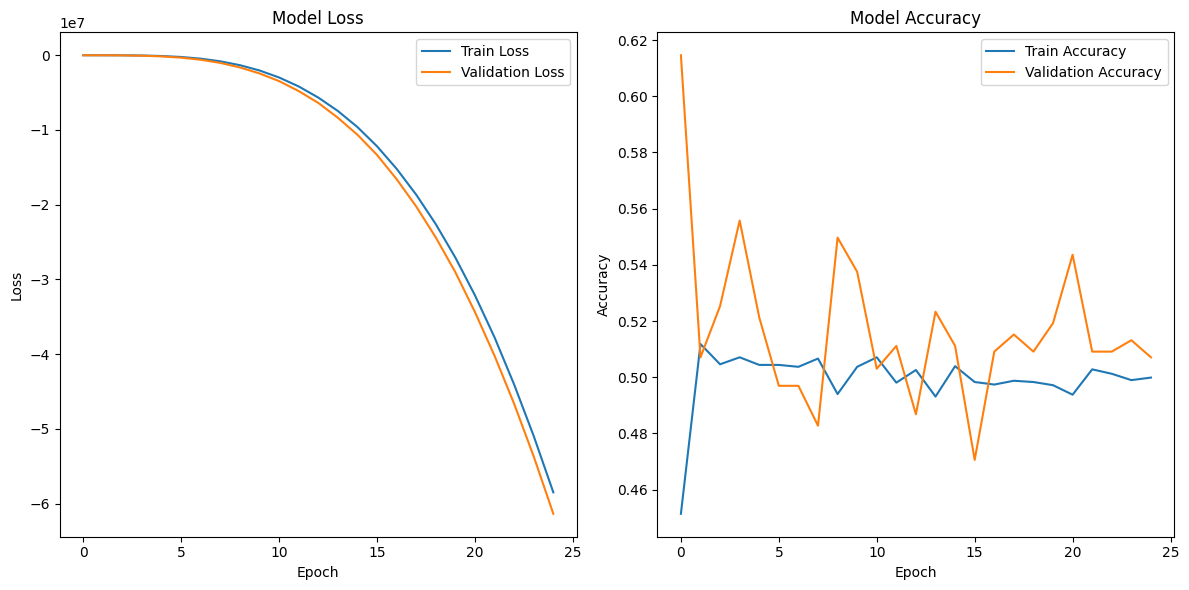

39/39 [==============================] - 0s 3ms/step - loss: -55333616.0000 - accuracy: 0.5130
Test Accuracy: 51.30%


In [16]:
# Define features (X) and target variable (y)
X = demographics[['Age', 'Race', 'BMI', 'LPS_Endotoxin', 'Perm_sucralose','S1', 'S2', 'S3', 'S4', 'S5', 'S6', 'S7', 'S8', 'S9', 'S10',
          'S11', 'S12', 'S13', 'S14', 'S15', 'S16', 'S17', 'S18', 'S19', 'S20',
          'S21', 'S22', 'S23', 'S24', 'S25', 'S26', 'S27', 'S28', 'S29', 'S30', 'S31', 'S32']]
y = demographics['group']  # Assuming 1 for Alcoholic Liver Disease and 2 for Parkinson's


# Split the dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Standardize the input features
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

# Reshape input data to include timesteps (if needed)
X_train = X_train[:, :, np.newaxis]
X_test = X_test[:, :, np.newaxis]

# Define your model architecture (update this according to your model's design)
def create_tcn_model(input_shape):
    model = keras.Sequential([
        layers.Input(shape=input_shape),
        layers.Conv1D(filters=64, kernel_size=3, activation='relu'),
        layers.MaxPooling1D(pool_size=2),
        layers.Conv1D(filters=128, kernel_size=3, activation='relu'),
        layers.MaxPooling1D(pool_size=2),
        layers.Flatten(),
        layers.Dense(64, activation='relu'),
        layers.Dense(1, activation='sigmoid')  # Sigmoid for binary classification
    ])
    return model

# Initialize and compile the model
input_shape = (X_train.shape[1], X_train.shape[2])
tcn_model = create_tcn_model(input_shape)
tcn_model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Train the model and save the history
epochs = 25  # Adjust the number of epochs as needed
batch_size = 32  # Adjust the batch size as needed
history = tcn_model.fit(X_train, y_train, epochs=epochs, batch_size=batch_size, validation_split=0.1)

# Plotting training & validation loss
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend()

# Plotting training & validation accuracy
plt.subplot(1, 2, 2)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend()

plt.tight_layout()
plt.show()

# Evaluate the model on the test set
test_loss, test_accuracy = tcn_model.evaluate(X_test, y_test)
print(f'Test Accuracy: {test_accuracy * 100:.2f}%')


### Only Sensors

Epoch 1/25
139/139 [==============================] - 4s 19ms/step - loss: -4.1102 - accuracy: 0.3141 - val_loss: -23.8915 - val_accuracy: 0.3144
Epoch 2/25
139/139 [==============================] - 2s 13ms/step - loss: -129.2958 - accuracy: 0.3862 - val_loss: -393.1418 - val_accuracy: 0.3915
Epoch 3/25
139/139 [==============================] - 2s 14ms/step - loss: -1055.3649 - accuracy: 0.3901 - val_loss: -2556.3174 - val_accuracy: 0.4929
Epoch 4/25
139/139 [==============================] - 3s 18ms/step - loss: -4492.8550 - accuracy: 0.3984 - val_loss: -8541.2881 - val_accuracy: 0.4361
Epoch 5/25
139/139 [==============================] - 1s 8ms/step - loss: -12895.5107 - accuracy: 0.4000 - val_loss: -22216.6465 - val_accuracy: 0.4726
Epoch 6/25
139/139 [==============================] - 1s 6ms/step - loss: -29542.7148 - accuracy: 0.3993 - val_loss: -45491.5195 - val_accuracy: 0.2941
Epoch 7/25
139/139 [==============================] - 1s 6ms/step - loss: -58870.0898 - accuracy: 0

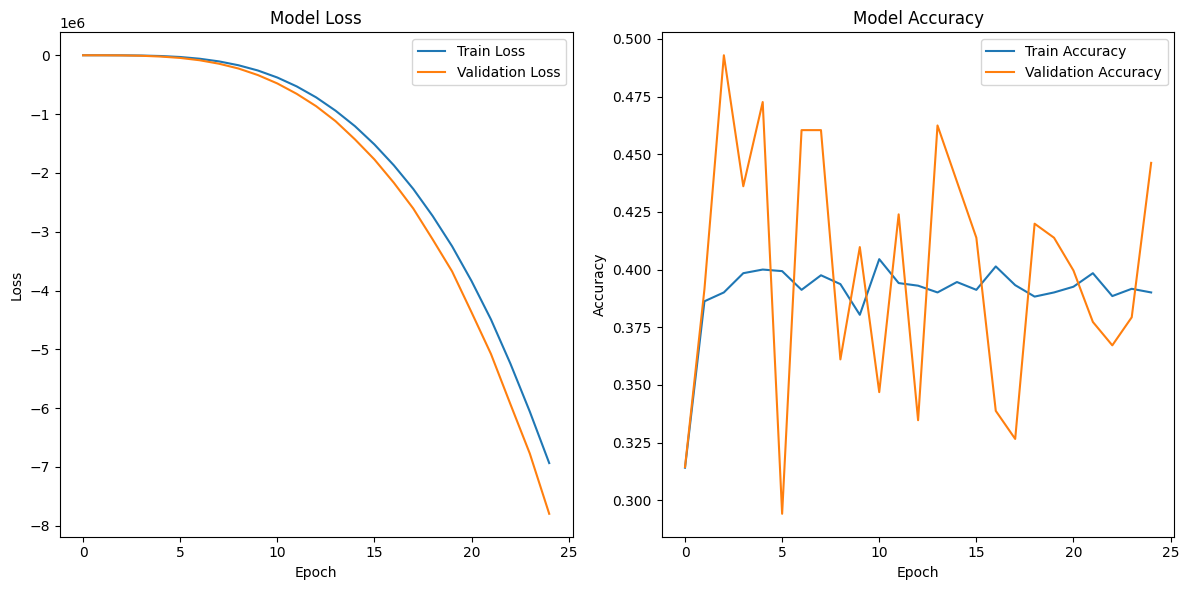

39/39 [==============================] - 0s 2ms/step - loss: -5871528.5000 - accuracy: 0.4586
Test Accuracy: 45.86%


In [17]:
# Define features (X) and target variable (y)
X = demographics[['S1', 'S2', 'S3', 'S4', 'S5', 'S6', 'S7', 'S8', 'S9', 'S10',
          'S11', 'S12', 'S13', 'S14', 'S15', 'S16', 'S17', 'S18', 'S19', 'S20',
          'S21', 'S22', 'S23', 'S24', 'S25', 'S26', 'S27', 'S28', 'S29', 'S30', 'S31', 'S32']]
y = demographics['group']  # Assuming 1 for Alcoholic Liver Disease and 2 for Parkinson's


# Split the dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Standardize the input features
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

# Reshape input data to include timesteps (if needed)
X_train = X_train[:, :, np.newaxis]
X_test = X_test[:, :, np.newaxis]

# Define your model architecture (update this according to your model's design)
def create_tcn_model(input_shape):
    model = keras.Sequential([
        layers.Input(shape=input_shape),
        layers.Conv1D(filters=64, kernel_size=3, activation='relu'),
        layers.MaxPooling1D(pool_size=2),
        layers.Conv1D(filters=128, kernel_size=3, activation='relu'),
        layers.MaxPooling1D(pool_size=2),
        layers.Flatten(),
        layers.Dense(64, activation='relu'),
        layers.Dense(1, activation='sigmoid')  # Sigmoid for binary classification
    ])
    return model

# Initialize and compile the model
input_shape = (X_train.shape[1], X_train.shape[2])
tcn_model = create_tcn_model(input_shape)
tcn_model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Train the model and save the history
epochs = 25  # Adjust the number of epochs as needed
batch_size = 32  # Adjust the batch size as needed
history = tcn_model.fit(X_train, y_train, epochs=epochs, batch_size=batch_size, validation_split=0.1)

# Plotting training & validation loss
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend()

# Plotting training & validation accuracy
plt.subplot(1, 2, 2)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend()

plt.tight_layout()
plt.show()

# Evaluate the model on the test set
test_loss, test_accuracy = tcn_model.evaluate(X_test, y_test)
print(f'Test Accuracy: {test_accuracy * 100:.2f}%')


## Random Forest Classifier


### All Inputs

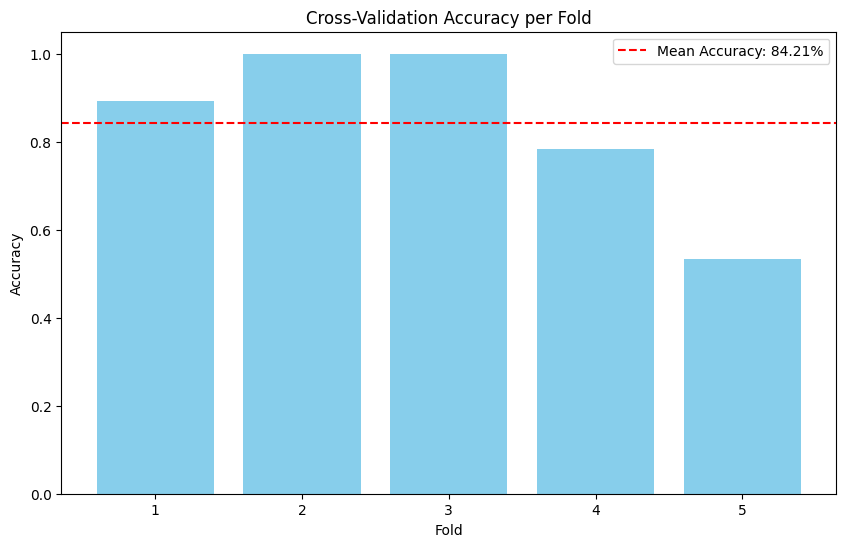

In [18]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

# Assuming the 'demographics' DataFrame is already loaded and preprocessed

# Define features (X) and target variable (y)
X = demographics[['Age', 'Race', 'BMI', 'LPS_Endotoxin', 'Perm_sucralose','S1', 'S2', 'S3', 'S4', 'S5', 'S6', 'S7', 'S8', 'S9', 'S10',
          'S11', 'S12', 'S13', 'S14', 'S15', 'S16', 'S17', 'S18', 'S19', 'S20',
          'S21', 'S22', 'S23', 'S24', 'S25', 'S26', 'S27', 'S28', 'S29', 'S30', 'S31', 'S32']]
y = demographics['group']  # Assuming 0 for Healthy Control and 1 for Alcoholic Liver Disease
selected_classes = [0, 1]
X_filtered = X[y.isin(selected_classes)]
y_filtered = y[y.isin(selected_classes)]

# Standardizing the features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X_filtered)

# Creating the RandomForestClassifier
rf_classifier = RandomForestClassifier(
    n_estimators=50,
    max_depth=10,
    min_samples_split=4,
    min_samples_leaf=2,
    random_state=None
)

# Performing cross-validation
cv_scores = cross_val_score(rf_classifier, X_scaled, y_filtered, cv=5)

# Visualizing the cross-validation scores
folds = range(1, len(cv_scores) + 1)
mean_score = np.mean(cv_scores)

plt.figure(figsize=(10, 6))
plt.bar(folds, cv_scores, color='skyblue')
plt.axhline(y=mean_score, color='r', linestyle='--', label=f'Mean Accuracy: {mean_score:.2%}')
plt.xlabel('Fold')
plt.ylabel('Accuracy')
plt.title('Cross-Validation Accuracy per Fold')
plt.xticks(folds)
plt.legend()
plt.show()

### Only Sensors

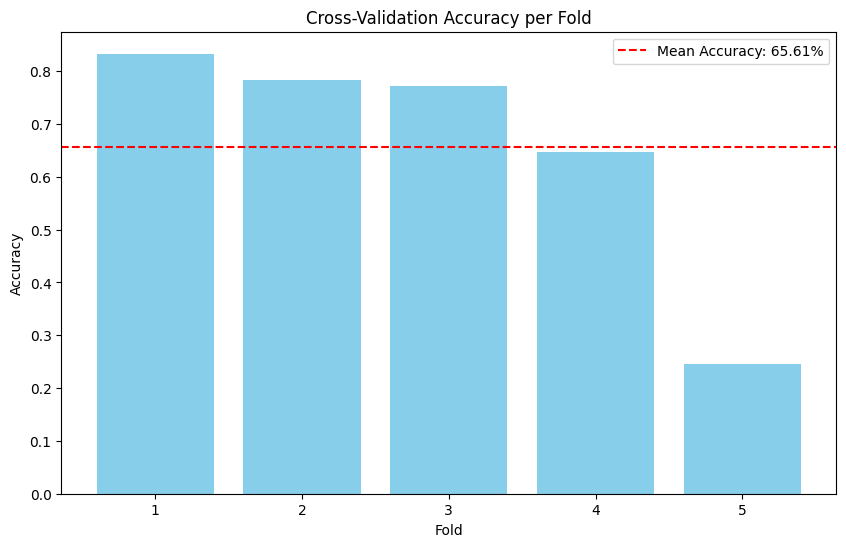

In [19]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

# Assuming the 'demographics' DataFrame is already loaded and preprocessed

# Define features (X) and target variable (y)
X = demographics[['S1', 'S2', 'S3', 'S4', 'S5', 'S6', 'S7', 'S8', 'S9', 'S10',
          'S11', 'S12', 'S13', 'S14', 'S15', 'S16', 'S17', 'S18', 'S19', 'S20',
          'S21', 'S22', 'S23', 'S24', 'S25', 'S26', 'S27', 'S28', 'S29', 'S30', 'S31', 'S32']]
y = demographics['group']  # Assuming 0 for Healthy Control and 1 for Alcoholic Liver Disease
selected_classes = [0, 1]
X_filtered = X[y.isin(selected_classes)]
y_filtered = y[y.isin(selected_classes)]

# Standardizing the features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X_filtered)

# Creating the RandomForestClassifier
rf_classifier = RandomForestClassifier(
    n_estimators=50,
    max_depth=10,
    min_samples_split=4,
    min_samples_leaf=2,
    random_state=None
)

# Performing cross-validation
cv_scores = cross_val_score(rf_classifier, X_scaled, y_filtered, cv=5)

# Visualizing the cross-validation scores
folds = range(1, len(cv_scores) + 1)
mean_score = np.mean(cv_scores)

plt.figure(figsize=(10, 6))
plt.bar(folds, cv_scores, color='skyblue')
plt.axhline(y=mean_score, color='r', linestyle='--', label=f'Mean Accuracy: {mean_score:.2%}')
plt.xlabel('Fold')
plt.ylabel('Accuracy')
plt.title('Cross-Validation Accuracy per Fold')
plt.xticks(folds)
plt.legend()
plt.show()

## xgBoost Classification Multiclass

### All Inputs

Streaming output truncated to the last 5000 lines.
[100]	validation_0-mlogloss:0.33206
[101]	validation_0-mlogloss:0.32847
[102]	validation_0-mlogloss:0.32493
[103]	validation_0-mlogloss:0.32143
[104]	validation_0-mlogloss:0.31796
[105]	validation_0-mlogloss:0.31454
[106]	validation_0-mlogloss:0.31116
[107]	validation_0-mlogloss:0.30782
[108]	validation_0-mlogloss:0.30452
[109]	validation_0-mlogloss:0.30126
[110]	validation_0-mlogloss:0.29803
[111]	validation_0-mlogloss:0.29484
[112]	validation_0-mlogloss:0.29169
[113]	validation_0-mlogloss:0.28857
[114]	validation_0-mlogloss:0.28549
[115]	validation_0-mlogloss:0.28245
[116]	validation_0-mlogloss:0.27944
[117]	validation_0-mlogloss:0.27646
[118]	validation_0-mlogloss:0.27352
[119]	validation_0-mlogloss:0.27061
[120]	validation_0-mlogloss:0.26774
[121]	validation_0-mlogloss:0.26490
[122]	validation_0-mlogloss:0.26209
[123]	validation_0-mlogloss:0.25931
[124]	validation_0-mlogloss:0.25656
[125]	validation_0-mlogloss:0.25385
[126]	validat

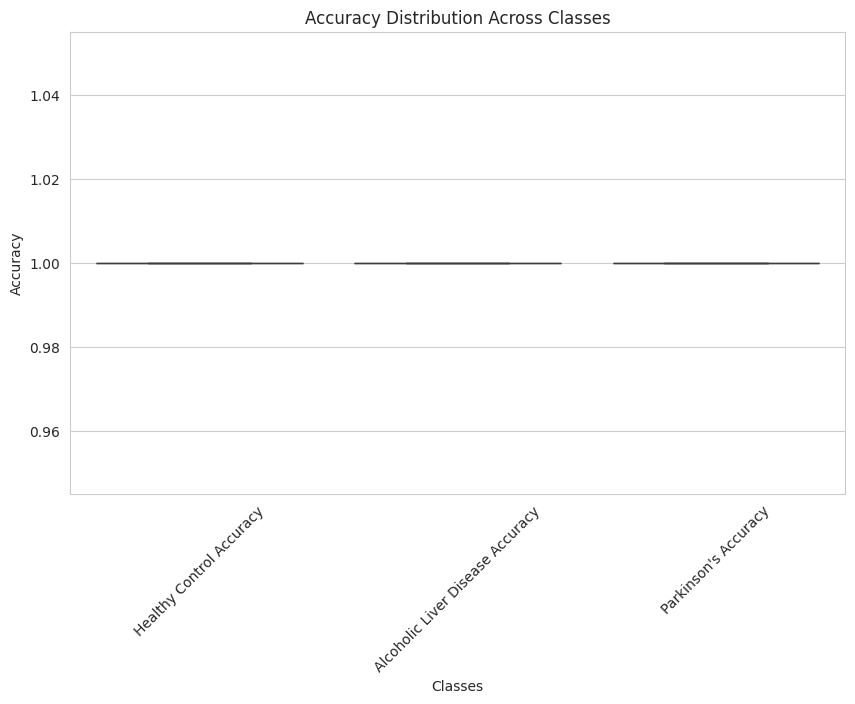

In [20]:
import warnings
import pandas as pd
from sklearn.model_selection import train_test_split
import xgboost as xgb
from sklearn.metrics import accuracy_score
import seaborn as sns
import matplotlib.pyplot as plt

# Suppress XGBoost-related warnings
warnings.filterwarnings('ignore', category=UserWarning, module='xgboost')

# Create an empty list to store DataFrames
results_list = []

# Define features (X) and target variable (y) for classification
X = demographics[['Age', 'Race', 'BMI', 'LPS_Endotoxin', 'Perm_sucralose','S1', 'S2', 'S3', 'S4', 'S5', 'S6', 'S7', 'S8', 'S9', 'S10',
          'S11', 'S12', 'S13', 'S14', 'S15', 'S16', 'S17', 'S18', 'S19', 'S20',
          'S21', 'S22', 'S23', 'S24', 'S25', 'S26', 'S27', 'S28', 'S29', 'S30', 'S31', 'S32']]
y = demographics['group']  # 0 for Healthy Control, 1 for Alcoholic Liver Disease, and 2 for Parkinson's

# Specify the number of iterations
num_iterations = 20

for iteration in range(num_iterations):
    # Split the dataset into training and testing sets with a random seed
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=iteration)

    # Create and train the XGBoost classifier with specific hyperparameters
    xgb_classifier = xgb.XGBClassifier(
        objective='multi:softmax',
        num_class=3,        # Number of classes
        random_state=42,
        n_estimators=300,  # Number of boosting rounds
        max_depth=5,       # Maximum tree depth
        learning_rate=0.01, # Learning rate
        subsample=0.8,     # Fraction of samples used for each tree
        verbosity=1        # Verbosity level
    )
    xgb_classifier.fit(X_train, y_train, eval_set=[(X_test, y_test)], eval_metric='mlogloss', verbose=True)

    # Predict disease labels on the test set
    y_pred = xgb_classifier.predict(X_test)

    # Calculate accuracy for each class
    accuracy_healthy_control = accuracy_score(y_test[y_test == 0], y_pred[y_test == 0])
    accuracy_alcoholic_liver_disease = accuracy_score(y_test[y_test == 1], y_pred[y_test == 1])
    accuracy_parkinsons = accuracy_score(y_test[y_test == 2], y_pred[y_test == 2])

    # Create a DataFrame for the current iteration with model information
    iteration_df = pd.DataFrame({
        'Iteration': [iteration + 1],
        'Healthy Control Accuracy': [accuracy_healthy_control],
        'Alcoholic Liver Disease Accuracy': [accuracy_alcoholic_liver_disease],
        'Parkinson\'s Accuracy': [accuracy_parkinsons],
        'Model Info': [str(xgb_classifier)],
    })

    # Append the DataFrame to the results list
    results_list.append(iteration_df)

# Concatenate all DataFrames in the results list
xgboost_classification_multiclass_results = pd.concat(results_list, ignore_index=True)

# Set the style of seaborn
sns.set_style("whitegrid")

# Create a box plot
plt.figure(figsize=(10, 6))
box_plot = sns.boxplot(data=xgboost_classification_multiclass_results.iloc[:, 1:4])
box_plot.set_title('Accuracy Distribution Across Classes')
box_plot.set_ylabel('Accuracy')
box_plot.set_xlabel('Classes')
plt.xticks(rotation=45)
plt.show()

In [21]:
xgboost_classification_multiclass_results.head()

,Iteration,Healthy Control Accuracy,Alcoholic Liver Disease Accuracy,Parkinson's Accuracy,Model Info
0,1,1.0,1.0,1.0,"XGBClassifier(base_score=None, booster=None, c..."
1,2,1.0,1.0,1.0,"XGBClassifier(base_score=None, booster=None, c..."
2,3,1.0,1.0,1.0,"XGBClassifier(base_score=None, booster=None, c..."
3,4,1.0,1.0,1.0,"XGBClassifier(base_score=None, booster=None, c..."
4,5,1.0,1.0,1.0,"XGBClassifier(base_score=None, booster=None, c..."


In [22]:
xgboost_classification_multiclass_results.to_csv('/content/drive/MyDrive/eNose/Outputs/csv_format/XGBoost_multiclass_allInputs.csv')
xgboost_classification_multiclass_results.to_html('/content/drive/MyDrive/eNose/Outputs/pdf_format/XGBoost_multiclass_allInputs.pdf')

### Only Sensors

Streaming output truncated to the last 5000 lines.
[100]	validation_0-mlogloss:0.75531
[101]	validation_0-mlogloss:0.75355
[102]	validation_0-mlogloss:0.75167
[103]	validation_0-mlogloss:0.74997
[104]	validation_0-mlogloss:0.74810
[105]	validation_0-mlogloss:0.74639
[106]	validation_0-mlogloss:0.74464
[107]	validation_0-mlogloss:0.74298
[108]	validation_0-mlogloss:0.74117
[109]	validation_0-mlogloss:0.73943
[110]	validation_0-mlogloss:0.73779
[111]	validation_0-mlogloss:0.73617
[112]	validation_0-mlogloss:0.73452
[113]	validation_0-mlogloss:0.73288
[114]	validation_0-mlogloss:0.73128
[115]	validation_0-mlogloss:0.72977
[116]	validation_0-mlogloss:0.72821
[117]	validation_0-mlogloss:0.72662
[118]	validation_0-mlogloss:0.72500
[119]	validation_0-mlogloss:0.72344
[120]	validation_0-mlogloss:0.72188
[121]	validation_0-mlogloss:0.72044
[122]	validation_0-mlogloss:0.71889
[123]	validation_0-mlogloss:0.71751
[124]	validation_0-mlogloss:0.71607
[125]	validation_0-mlogloss:0.71471
[126]	validat

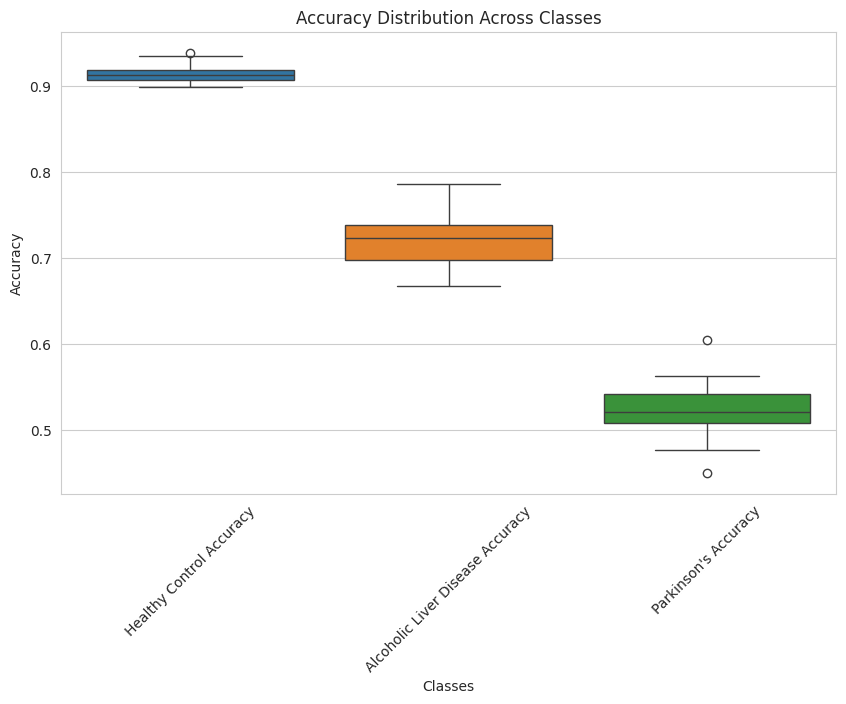

In [23]:
import warnings
import pandas as pd
from sklearn.model_selection import train_test_split
import xgboost as xgb
from sklearn.metrics import accuracy_score
import seaborn as sns
import matplotlib.pyplot as plt

# Suppress XGBoost-related warnings
warnings.filterwarnings('ignore', category=UserWarning, module='xgboost')

# Create an empty list to store DataFrames
results_list = []

# Define features (X) and target variable (y) for classification
X = demographics[['S1', 'S2', 'S3', 'S4', 'S5', 'S6', 'S7', 'S8', 'S9', 'S10',
          'S11', 'S12', 'S13', 'S14', 'S15', 'S16', 'S17', 'S18', 'S19', 'S20',
          'S21', 'S22', 'S23', 'S24', 'S25', 'S26', 'S27', 'S28', 'S29', 'S30', 'S31', 'S32']]
y = demographics['group']  # 0 for Healthy Control, 1 for Alcoholic Liver Disease, and 2 for Parkinson's

# Specify the number of iterations
num_iterations = 20

for iteration in range(num_iterations):
    # Split the dataset into training and testing sets with a random seed
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=iteration)

    # Create and train the XGBoost classifier with specific hyperparameters
    xgb_classifier = xgb.XGBClassifier(
        objective='multi:softmax',
        num_class=3,        # Number of classes
        random_state=42,
        n_estimators=300,  # Number of boosting rounds
        max_depth=5,       # Maximum tree depth
        learning_rate=0.01, # Learning rate
        subsample=0.8,     # Fraction of samples used for each tree
        verbosity=1        # Verbosity level
    )
    xgb_classifier.fit(X_train, y_train, eval_set=[(X_test, y_test)], eval_metric='mlogloss', verbose=True)

    # Predict disease labels on the test set
    y_pred = xgb_classifier.predict(X_test)

    # Calculate accuracy for each class
    accuracy_healthy_control = accuracy_score(y_test[y_test == 0], y_pred[y_test == 0])
    accuracy_alcoholic_liver_disease = accuracy_score(y_test[y_test == 1], y_pred[y_test == 1])
    accuracy_parkinsons = accuracy_score(y_test[y_test == 2], y_pred[y_test == 2])

    # Create a DataFrame for the current iteration with model information
    iteration_df = pd.DataFrame({
        'Iteration': [iteration + 1],
        'Healthy Control Accuracy': [accuracy_healthy_control],
        'Alcoholic Liver Disease Accuracy': [accuracy_alcoholic_liver_disease],
        'Parkinson\'s Accuracy': [accuracy_parkinsons],
        'Model Info': [str(xgb_classifier)],
    })

    # Append the DataFrame to the results list
    results_list.append(iteration_df)

# Concatenate all DataFrames in the results list
xgboost_classification_multiclass_results = pd.concat(results_list, ignore_index=True)

# Set the style of seaborn
sns.set_style("whitegrid")

# Create a box plot
plt.figure(figsize=(10, 6))
box_plot = sns.boxplot(data=xgboost_classification_multiclass_results.iloc[:, 1:4])
box_plot.set_title('Accuracy Distribution Across Classes')
box_plot.set_ylabel('Accuracy')
box_plot.set_xlabel('Classes')
plt.xticks(rotation=45)
plt.show()

In [24]:
xgboost_classification_multiclass_results.head()

,Iteration,Healthy Control Accuracy,Alcoholic Liver Disease Accuracy,Parkinson's Accuracy,Model Info
0,1,0.935323,0.702941,0.512111,"XGBClassifier(base_score=None, booster=None, c..."
1,2,0.913793,0.690962,0.521036,"XGBClassifier(base_score=None, booster=None, c..."
2,3,0.918831,0.698462,0.542955,"XGBClassifier(base_score=None, booster=None, c..."
3,4,0.916248,0.671554,0.520408,"XGBClassifier(base_score=None, booster=None, c..."
4,5,0.913118,0.736527,0.508039,"XGBClassifier(base_score=None, booster=None, c..."


In [25]:
xgboost_classification_multiclass_results.to_csv('/content/drive/MyDrive/eNose/Outputs/csv_format/XGBoost_multiclass_onlySensors.csv')
xgboost_classification_multiclass_results.to_html('/content/drive/MyDrive/eNose/Outputs/pdf_format/XGBoost_multiclass_onlySensors.pdf')

## xgBoost Classification Binary

### All Inputs

In [26]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import xgboost as xgb
from sklearn.metrics import accuracy_score

X = demographics[['Age', 'Race', 'BMI', 'LPS_Endotoxin', 'Perm_sucralose','S1', 'S2', 'S3', 'S4', 'S5', 'S6', 'S7', 'S8', 'S9', 'S10',
          'S11', 'S12', 'S13', 'S14', 'S15', 'S16', 'S17', 'S18', 'S19', 'S20',
          'S21', 'S22', 'S23', 'S24', 'S25', 'S26', 'S27', 'S28', 'S29', 'S30', 'S31', 'S32']]
y = demographics['group']  # Assuming 0 for Healthy Control and 1 for Alcoholic Liver Disease

# Filter the dataset to include only "Healthy Control" (0) and "Alcoholic Liver Disease" (1)
selected_classes = [0, 1]
X_filtered = X[y.isin(selected_classes)]
y_filtered = y[y.isin(selected_classes)]

# Split the filtered dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X_filtered, y_filtered, test_size=0.2, random_state=42)

# Standardize the input features (important for XGBoost)
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

# Create and train the XGBoost classifier
xgb_classifier = xgb.XGBClassifier(objective='binary:logistic', random_state=42)
xgb_classifier.fit(X_train, y_train)

# Predict using the trained XGBoost classifier
y_pred = xgb_classifier.predict(X_test)

# Calculate accuracy on the test set
accuracy = accuracy_score(y_test, y_pred)
print(f'Test Accuracy: {accuracy * 100:.2f}%')


Test Accuracy: 100.00%


### Only Sensors

In [27]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import xgboost as xgb
from sklearn.metrics import accuracy_score

X = demographics[['S1', 'S2', 'S3', 'S4', 'S5', 'S6', 'S7', 'S8', 'S9', 'S10',
          'S11', 'S12', 'S13', 'S14', 'S15', 'S16', 'S17', 'S18', 'S19', 'S20',
          'S21', 'S22', 'S23', 'S24', 'S25', 'S26', 'S27', 'S28', 'S29', 'S30', 'S31', 'S32']]
y = demographics['group']  # Assuming 0 for Healthy Control and 1 for Alcoholic Liver Disease

# Filter the dataset to include only "Healthy Control" (0) and "Alcoholic Liver Disease" (1)
selected_classes = [0, 1]
X_filtered = X[y.isin(selected_classes)]
y_filtered = y[y.isin(selected_classes)]

# Split the filtered dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X_filtered, y_filtered, test_size=0.2, random_state=42)

# Standardize the input features (important for XGBoost)
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

# Create and train the XGBoost classifier
xgb_classifier = xgb.XGBClassifier(objective='binary:logistic', random_state=42)
xgb_classifier.fit(X_train, y_train)

# Predict using the trained XGBoost classifier
y_pred = xgb_classifier.predict(X_test)

# Calculate accuracy on the test set
accuracy = accuracy_score(y_test, y_pred)
print(f'Test Accuracy: {accuracy * 100:.2f}%')


Test Accuracy: 93.53%


## Multilayer Perceptron (MLP)

### All Inputs

In [28]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import tensorflow as tf
from tensorflow import keras
from sklearn.metrics import accuracy_score

X = demographics[['Age', 'Race', 'BMI', 'LPS_Endotoxin', 'Perm_sucralose','S1', 'S2', 'S3', 'S4', 'S5', 'S6', 'S7', 'S8', 'S9', 'S10',
          'S11', 'S12', 'S13', 'S14', 'S15', 'S16', 'S17', 'S18', 'S19', 'S20',
          'S21', 'S22', 'S23', 'S24', 'S25', 'S26', 'S27', 'S28', 'S29', 'S30', 'S31', 'S32']]
y = demographics['group']  # Assuming 0 for Healthy Control and 1 for Alcoholic Liver Disease

# Filter the dataset to include only "Healthy Control" (0) and "Alcoholic Liver Disease" (1)
selected_classes = [0, 1]
X_filtered = X[y.isin(selected_classes)]
y_filtered = y[y.isin(selected_classes)]

# Split the filtered dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X_filtered, y_filtered, test_size=0.2, random_state=42)

# Standardize the input features (important for neural networks)
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

# Create a simple neural network model
model = keras.Sequential([
    keras.layers.Input(shape=(X_train.shape[1],)),  # Input layer
    keras.layers.Dense(64, activation='relu'),     # Hidden layer with 64 neurons and ReLU activation
    keras.layers.Dense(1, activation='sigmoid')    # Output layer with sigmoid activation for binary classification
])

# Compile the model
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Train the neural network on your data
model.fit(X_train, y_train, epochs=20, batch_size=32, validation_split=0.2)

# Evaluate the model on the test set
y_pred = (model.predict(X_test) > 0.5).astype(int)  # Convert probabilities to binary predictions
accuracy = accuracy_score(y_test, y_pred)
print(f'Test Accuracy: {accuracy * 100:.2f}%')


Epoch 1/20
93/93 [==============================] - 1s 4ms/step - loss: 0.3152 - accuracy: 0.9043 - val_loss: 0.1728 - val_accuracy: 0.9812
Epoch 2/20
93/93 [==============================] - 0s 3ms/step - loss: 0.1113 - accuracy: 0.9875 - val_loss: 0.0713 - val_accuracy: 0.9973
Epoch 3/20
93/93 [==============================] - 0s 3ms/step - loss: 0.0490 - accuracy: 0.9983 - val_loss: 0.0339 - val_accuracy: 1.0000
Epoch 4/20
93/93 [==============================] - 0s 3ms/step - loss: 0.0251 - accuracy: 0.9997 - val_loss: 0.0193 - val_accuracy: 1.0000
Epoch 5/20
93/93 [==============================] - 0s 2ms/step - loss: 0.0150 - accuracy: 1.0000 - val_loss: 0.0123 - val_accuracy: 1.0000
Epoch 6/20
93/93 [==============================] - 0s 3ms/step - loss: 0.0099 - accuracy: 1.0000 - val_loss: 0.0086 - val_accuracy: 1.0000
Epoch 7/20
93/93 [==============================] - 0s 2ms/step - loss: 0.0070 - accuracy: 1.0000 - val_loss: 0.0065 - val_accuracy: 1.0000
Epoch 8/20
93/93 [==

### Only Sensors

In [29]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import tensorflow as tf
from tensorflow import keras
from sklearn.metrics import accuracy_score

X = demographics[['S1', 'S2', 'S3', 'S4', 'S5', 'S6', 'S7', 'S8', 'S9', 'S10',
          'S11', 'S12', 'S13', 'S14', 'S15', 'S16', 'S17', 'S18', 'S19', 'S20',
          'S21', 'S22', 'S23', 'S24', 'S25', 'S26', 'S27', 'S28', 'S29', 'S30', 'S31', 'S32']]
y = demographics['group']  # Assuming 0 for Healthy Control and 1 for Alcoholic Liver Disease

# Filter the dataset to include only "Healthy Control" (0) and "Alcoholic Liver Disease" (1)
selected_classes = [0, 1]
X_filtered = X[y.isin(selected_classes)]
y_filtered = y[y.isin(selected_classes)]

# Split the filtered dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X_filtered, y_filtered, test_size=0.2, random_state=42)

# Standardize the input features (important for neural networks)
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

# Create a simple neural network model
model = keras.Sequential([
    keras.layers.Input(shape=(X_train.shape[1],)),  # Input layer
    keras.layers.Dense(64, activation='relu'),     # Hidden layer with 64 neurons and ReLU activation
    keras.layers.Dense(1, activation='sigmoid')    # Output layer with sigmoid activation for binary classification
])

# Compile the model
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Train the neural network on your data
model.fit(X_train, y_train, epochs=20, batch_size=32, validation_split=0.2)

# Evaluate the model on the test set
y_pred = (model.predict(X_test) > 0.5).astype(int)  # Convert probabilities to binary predictions
accuracy = accuracy_score(y_test, y_pred)
print(f'Test Accuracy: {accuracy * 100:.2f}%')


Epoch 1/20
93/93 [==============================] - 1s 5ms/step - loss: 0.5099 - accuracy: 0.7652 - val_loss: 0.4334 - val_accuracy: 0.8358
Epoch 2/20
93/93 [==============================] - 0s 4ms/step - loss: 0.4312 - accuracy: 0.8231 - val_loss: 0.4021 - val_accuracy: 0.8385
Epoch 3/20
93/93 [==============================] - 0s 4ms/step - loss: 0.4075 - accuracy: 0.8322 - val_loss: 0.3958 - val_accuracy: 0.8345
Epoch 4/20
93/93 [==============================] - 0s 4ms/step - loss: 0.3915 - accuracy: 0.8376 - val_loss: 0.3759 - val_accuracy: 0.8398
Epoch 5/20
93/93 [==============================] - 0s 4ms/step - loss: 0.3794 - accuracy: 0.8477 - val_loss: 0.3751 - val_accuracy: 0.8398
Epoch 6/20
93/93 [==============================] - 0s 3ms/step - loss: 0.3740 - accuracy: 0.8494 - val_loss: 0.3639 - val_accuracy: 0.8398
Epoch 7/20
93/93 [==============================] - 0s 3ms/step - loss: 0.3641 - accuracy: 0.8487 - val_loss: 0.3636 - val_accuracy: 0.8345
Epoch 8/20
93/93 [==

## Long Short-Term Memory (LSTM)

### All inputs

In [30]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import tensorflow as tf
from tensorflow import keras
from sklearn.metrics import accuracy_score

X = demographics[['Age', 'Race', 'BMI', 'LPS_Endotoxin', 'Perm_sucralose','S1', 'S2', 'S3', 'S4', 'S5', 'S6', 'S7', 'S8', 'S9', 'S10',
          'S11', 'S12', 'S13', 'S14', 'S15', 'S16', 'S17', 'S18', 'S19', 'S20',
          'S21', 'S22', 'S23', 'S24', 'S25', 'S26', 'S27', 'S28', 'S29', 'S30', 'S31', 'S32']]
y = demographics['group']  # Assuming 0 for Healthy Control and 1 for Alcoholic Liver Disease

# Filter the dataset to include only "Healthy Control" (0) and "Alcoholic Liver Disease" (1)
selected_classes = [0, 1]
X_filtered = X[y.isin(selected_classes)]
y_filtered = y[y.isin(selected_classes)]

# Split the filtered dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X_filtered, y_filtered, test_size=0.2, random_state=42)

# Standardize the input features (important for neural networks)
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

# Reshape data for LSTM (assuming time steps)
n_features = X_train.shape[1]
X_train = X_train.reshape(-1, 1, n_features)
X_test = X_test.reshape(-1, 1, n_features)

# Create an LSTM-based model
model = keras.Sequential([
    keras.layers.LSTM(64, activation='relu', input_shape=(1, n_features)),
    keras.layers.Dense(1, activation='sigmoid')  # Output layer with sigmoid activation for binary classification
])

# Compile the model
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Train the LSTM model on your data
model.fit(X_train, y_train, epochs=20, batch_size=32, validation_split=0.2)

# Evaluate the model on the test set
y_pred = (model.predict(X_test) > 0.5).astype(int)  # Convert probabilities to binary predictions
accuracy = accuracy_score(y_test, y_pred)
print(f'Test Accuracy: {accuracy * 100:.2f}%')


Epoch 1/20
93/93 [==============================] - 3s 9ms/step - loss: 0.4436 - accuracy: 0.8167 - val_loss: 0.2836 - val_accuracy: 0.8977
Epoch 2/20
93/93 [==============================] - 0s 4ms/step - loss: 0.1838 - accuracy: 0.9589 - val_loss: 0.0965 - val_accuracy: 0.9973
Epoch 3/20
93/93 [==============================] - 0s 4ms/step - loss: 0.0592 - accuracy: 0.9980 - val_loss: 0.0342 - val_accuracy: 1.0000
Epoch 4/20
93/93 [==============================] - 0s 5ms/step - loss: 0.0240 - accuracy: 0.9997 - val_loss: 0.0163 - val_accuracy: 1.0000
Epoch 5/20
93/93 [==============================] - 0s 3ms/step - loss: 0.0124 - accuracy: 1.0000 - val_loss: 0.0095 - val_accuracy: 1.0000
Epoch 6/20
93/93 [==============================] - 1s 7ms/step - loss: 0.0074 - accuracy: 1.0000 - val_loss: 0.0060 - val_accuracy: 1.0000
Epoch 7/20
93/93 [==============================] - 0s 5ms/step - loss: 0.0049 - accuracy: 1.0000 - val_loss: 0.0042 - val_accuracy: 1.0000
Epoch 8/20
93/93 [==

### Only Sensors

In [31]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import tensorflow as tf
from tensorflow import keras
from sklearn.metrics import accuracy_score

X = demographics[['S1', 'S2', 'S3', 'S4', 'S5', 'S6', 'S7', 'S8', 'S9', 'S10',
          'S11', 'S12', 'S13', 'S14', 'S15', 'S16', 'S17', 'S18', 'S19', 'S20',
          'S21', 'S22', 'S23', 'S24', 'S25', 'S26', 'S27', 'S28', 'S29', 'S30', 'S31', 'S32']]
y = demographics['group']  # Assuming 0 for Healthy Control and 1 for Alcoholic Liver Disease

# Filter the dataset to include only "Healthy Control" (0) and "Alcoholic Liver Disease" (1)
selected_classes = [0, 1]
X_filtered = X[y.isin(selected_classes)]
y_filtered = y[y.isin(selected_classes)]

# Split the filtered dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X_filtered, y_filtered, test_size=0.2, random_state=42)

# Standardize the input features (important for neural networks)
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

# Reshape data for LSTM (assuming time steps)
n_features = X_train.shape[1]
X_train = X_train.reshape(-1, 1, n_features)
X_test = X_test.reshape(-1, 1, n_features)

# Create an LSTM-based model
model = keras.Sequential([
    keras.layers.LSTM(64, activation='relu', input_shape=(1, n_features)),
    keras.layers.Dense(1, activation='sigmoid')  # Output layer with sigmoid activation for binary classification
])

# Compile the model
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Train the LSTM model on your data
model.fit(X_train, y_train, epochs=20, batch_size=32, validation_split=0.2)

# Evaluate the model on the test set
y_pred = (model.predict(X_test) > 0.5).astype(int)  # Convert probabilities to binary predictions
accuracy = accuracy_score(y_test, y_pred)
print(f'Test Accuracy: {accuracy * 100:.2f}%')


Epoch 1/20
93/93 [==============================] - 2s 6ms/step - loss: 0.5238 - accuracy: 0.7874 - val_loss: 0.4614 - val_accuracy: 0.8304
Epoch 2/20
93/93 [==============================] - 0s 3ms/step - loss: 0.4588 - accuracy: 0.8130 - val_loss: 0.4274 - val_accuracy: 0.8358
Epoch 3/20
93/93 [==============================] - 0s 3ms/step - loss: 0.4319 - accuracy: 0.8170 - val_loss: 0.4098 - val_accuracy: 0.8345
Epoch 4/20
93/93 [==============================] - 0s 3ms/step - loss: 0.4082 - accuracy: 0.8268 - val_loss: 0.3873 - val_accuracy: 0.8439
Epoch 5/20
93/93 [==============================] - 0s 4ms/step - loss: 0.3824 - accuracy: 0.8396 - val_loss: 0.3645 - val_accuracy: 0.8345
Epoch 6/20
93/93 [==============================] - 0s 3ms/step - loss: 0.3652 - accuracy: 0.8491 - val_loss: 0.3671 - val_accuracy: 0.8371
Epoch 7/20
93/93 [==============================] - 0s 4ms/step - loss: 0.3490 - accuracy: 0.8501 - val_loss: 0.3389 - val_accuracy: 0.8398
Epoch 8/20
93/93 [==

## AdaBoost

### All Inputs

In [32]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import AdaBoostClassifier
from sklearn.metrics import accuracy_score

X = demographics[['Age', 'Race', 'BMI', 'LPS_Endotoxin', 'Perm_sucralose','S1', 'S2', 'S3', 'S4', 'S5', 'S6', 'S7', 'S8', 'S9', 'S10',
          'S11', 'S12', 'S13', 'S14', 'S15', 'S16', 'S17', 'S18', 'S19', 'S20',
          'S21', 'S22', 'S23', 'S24', 'S25', 'S26', 'S27', 'S28', 'S29', 'S30', 'S31', 'S32']]
y = demographics['group']  # Assuming 0 for Healthy Control and 1 for Alcoholic Liver Disease

# Filter the dataset to include only "Healthy Control" (0) and "Alcoholic Liver Disease" (1)
selected_classes = [0, 1]
X_filtered = X[y.isin(selected_classes)]
y_filtered = y[y.isin(selected_classes)]

# Split the filtered dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X_filtered, y_filtered, test_size=0.2, random_state=42)

# Standardize the input features (important for neural networks)
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

# Reshape data for LSTM (assuming time steps)
n_features = X_train.shape[1]
X_train = X_train.reshape(-1, 1, n_features)
X_test = X_test.reshape(-1, 1, n_features)

# Create an LSTM-based model
model = keras.Sequential([
    keras.layers.LSTM(64, activation='relu', input_shape=(1, n_features)),
    keras.layers.Dense(1, activation='sigmoid')  # Output layer with sigmoid activation for binary classification
])

# Compile the model
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Train the LSTM model on your data
model.fit(X_train, y_train, epochs=20, batch_size=32, validation_split=0.2)

# Evaluate the model on the test set
y_pred = (model.predict(X_test) > 0.5).astype(int)  # Convert probabilities to binary predictions
accuracy = accuracy_score(y_test, y_pred)
print(f'Test Accuracy: {accuracy * 100:.2f}%')

y = demographics['group']  # Assuming 0 for Healthy Control and 1 for Alcoholic Liver Disease

# Filter the dataset to include only "Healthy Control" (0) and "Alcoholic Liver Disease" (1)
selected_classes = [0, 1]
X_filtered = X[y.isin(selected_classes)]
y_filtered = y[y.isin(selected_classes)]

# Split the filtered dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X_filtered, y_filtered, test_size=0.2, random_state=42)

# Standardize the input features (important for AdaBoost)
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

# Create an AdaBoost classifier with a decision tree as the base estimator
adaboost_classifier = AdaBoostClassifier(n_estimators=50, random_state=42)

# Train the AdaBoost classifier on your data
adaboost_classifier.fit(X_train, y_train)

# Predict using the trained AdaBoost classifier
y_pred = adaboost_classifier.predict(X_test)

# Calculate accuracy on the test set
accuracy = accuracy_score(y_test, y_pred)
print(f'Test Accuracy: {accuracy * 100:.2f}%')


Epoch 1/20
93/93 [==============================] - 2s 6ms/step - loss: 0.4192 - accuracy: 0.8467 - val_loss: 0.2698 - val_accuracy: 0.8991
Epoch 2/20
93/93 [==============================] - 0s 4ms/step - loss: 0.1714 - accuracy: 0.9653 - val_loss: 0.0888 - val_accuracy: 0.9960
Epoch 3/20
93/93 [==============================] - 0s 4ms/step - loss: 0.0552 - accuracy: 0.9980 - val_loss: 0.0320 - val_accuracy: 0.9987
Epoch 4/20
93/93 [==============================] - 0s 4ms/step - loss: 0.0223 - accuracy: 0.9997 - val_loss: 0.0154 - val_accuracy: 1.0000
Epoch 5/20
93/93 [==============================] - 0s 4ms/step - loss: 0.0113 - accuracy: 1.0000 - val_loss: 0.0086 - val_accuracy: 1.0000
Epoch 6/20
93/93 [==============================] - 0s 3ms/step - loss: 0.0066 - accuracy: 1.0000 - val_loss: 0.0055 - val_accuracy: 1.0000
Epoch 7/20
93/93 [==============================] - 0s 4ms/step - loss: 0.0043 - accuracy: 1.0000 - val_loss: 0.0038 - val_accuracy: 1.0000
Epoch 8/20
93/93 [==

### Only Sensors

In [33]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import tensorflow as tf
from tensorflow import keras
from sklearn.metrics import accuracy_score

# Load your merged_df dataset and preprocess it (as you've done)
# Define features (X) and target variable (y)
X = demographics[['S1', 'S2', 'S3', 'S4', 'S5', 'S6', 'S7', 'S8', 'S9', 'S10',
          'S11', 'S12', 'S13', 'S14', 'S15', 'S16', 'S17', 'S18', 'S19', 'S20',
          'S21', 'S22', 'S23', 'S24', 'S25', 'S26', 'S27', 'S28', 'S29', 'S30', 'S31', 'S32']]
y = demographics['group']  # Assuming 0 for Healthy Control and 1 for Alcoholic Liver Disease

# Filter the dataset to include only "Healthy Control" (0) and "Alcoholic Liver Disease" (1)
selected_classes = [0, 1]
X_filtered = X[y.isin(selected_classes)]
y_filtered = y[y.isin(selected_classes)]

# Split the filtered dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X_filtered, y_filtered, test_size=0.2, random_state=42)

# Standardize the input features (important for neural networks)
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

# Reshape data for LSTM (assuming time steps)
n_features = X_train.shape[1]
X_train = X_train.reshape(-1, 1, n_features)
X_test = X_test.reshape(-1, 1, n_features)

# Create an LSTM-based model
model = keras.Sequential([
    keras.layers.LSTM(64, activation='relu', input_shape=(1, n_features)),
    keras.layers.Dense(1, activation='sigmoid')  # Output layer with sigmoid activation for binary classification
])

# Compile the model
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Train the LSTM model on your data
model.fit(X_train, y_train, epochs=20, batch_size=32, validation_split=0.2)

# Evaluate the model on the test set
y_pred = (model.predict(X_test) > 0.5).astype(int)  # Convert probabilities to binary predictions
accuracy = accuracy_score(y_test, y_pred)
print(f'Test Accuracy: {accuracy * 100:.2f}%')


Epoch 1/20
93/93 [==============================] - 2s 6ms/step - loss: 0.5253 - accuracy: 0.7941 - val_loss: 0.4681 - val_accuracy: 0.8371
Epoch 2/20
93/93 [==============================] - 0s 3ms/step - loss: 0.4624 - accuracy: 0.8147 - val_loss: 0.4318 - val_accuracy: 0.8385
Epoch 3/20
93/93 [==============================] - 0s 3ms/step - loss: 0.4356 - accuracy: 0.8235 - val_loss: 0.4092 - val_accuracy: 0.8345
Epoch 4/20
93/93 [==============================] - 0s 3ms/step - loss: 0.4146 - accuracy: 0.8272 - val_loss: 0.3883 - val_accuracy: 0.8385
Epoch 5/20
93/93 [==============================] - 0s 3ms/step - loss: 0.3884 - accuracy: 0.8393 - val_loss: 0.3725 - val_accuracy: 0.8371
Epoch 6/20
93/93 [==============================] - 0s 4ms/step - loss: 0.3691 - accuracy: 0.8484 - val_loss: 0.3524 - val_accuracy: 0.8398
Epoch 7/20
93/93 [==============================] - 0s 3ms/step - loss: 0.3519 - accuracy: 0.8501 - val_loss: 0.3392 - val_accuracy: 0.8398
Epoch 8/20
93/93 [==

# **Chosen algorithm: xgBoost Classification Binary**

### Accuracy

#### All Inputs

In [34]:
import warnings
import pandas as pd
from sklearn.model_selection import train_test_split
import xgboost as xgb
from sklearn.metrics import accuracy_score

# Suppress XGBoost-related warnings
warnings.filterwarnings('ignore', category=UserWarning, module='xgboost')

# Create an empty list to store DataFrames
results_list = []

X = demographics[['Age', 'Race', 'BMI', 'LPS_Endotoxin', 'Perm_sucralose','S1', 'S2', 'S3', 'S4', 'S5', 'S6', 'S7', 'S8', 'S9', 'S10',
          'S11', 'S12', 'S13', 'S14', 'S15', 'S16', 'S17', 'S18', 'S19', 'S20',
          'S21', 'S22', 'S23', 'S24', 'S25', 'S26', 'S27', 'S28', 'S29', 'S30', 'S31', 'S32']]
y = demographics['group']  # 0 for Healthy Control, 1 for Alcoholic Liver Disease, and 2 for Parkinson's

# Specify the number of iterations
num_iterations = 32

for iteration in range(num_iterations):
    # Split the dataset into training and testing sets with a random seed
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=iteration)

    # Create and train the XGBoost classifier with specific hyperparameters
    xgb_classifier = xgb.XGBClassifier(
        objective='binary:logistic',
        random_state=42,
        n_estimators=100,  # Number of boosting rounds
        max_depth=6,       # Maximum tree depth
        learning_rate=0.1, # Learning rate
        subsample=0.8,     # Fraction of samples used for each tree
    )
    xgb_classifier.fit(X_train, y_train)

    # Predict disease labels on the test set
    y_pred = xgb_classifier.predict(X_test)

    # Calculate accuracy for each class
    accuracy_healthy_control = accuracy_score(y_test[y_test == 0], y_pred[y_test == 0])
    accuracy_alcoholic_liver_disease = accuracy_score(y_test[y_test == 1], y_pred[y_test == 1])
    accuracy_parkinsons = accuracy_score(y_test[y_test == 2], y_pred[y_test == 2])

    # Create a DataFrame for the current iteration with model information
    iteration_df = pd.DataFrame({
        'Iteration': [iteration + 1],
        'Healthy Control Accuracy': [accuracy_healthy_control],
        'Alcoholic Liver Disease Accuracy': [accuracy_alcoholic_liver_disease],
        'Parkinson\'s Accuracy': [accuracy_parkinsons],
        'Model Info': [str(xgb_classifier)],
    })

    # Append the DataFrame to the results list
    results_list.append(iteration_df)

# Concatenate all DataFrames in the results list
xgboost_classification_binary_accuracy_results = pd.concat(results_list, ignore_index=True)

# Display the results DataFrame
xgboost_classification_binary_accuracy_results.head(num_iterations)


,Iteration,Healthy Control Accuracy,Alcoholic Liver Disease Accuracy,Parkinson's Accuracy,Model Info
0,1,1.0,1.0,1.0,"XGBClassifier(base_score=None, booster=None, c..."
1,2,1.0,1.0,1.0,"XGBClassifier(base_score=None, booster=None, c..."
2,3,1.0,1.0,1.0,"XGBClassifier(base_score=None, booster=None, c..."
3,4,1.0,1.0,1.0,"XGBClassifier(base_score=None, booster=None, c..."
4,5,1.0,1.0,1.0,"XGBClassifier(base_score=None, booster=None, c..."
5,6,1.0,1.0,1.0,"XGBClassifier(base_score=None, booster=None, c..."
6,7,1.0,1.0,1.0,"XGBClassifier(base_score=None, booster=None, c..."
7,8,1.0,1.0,1.0,"XGBClassifier(base_score=None, booster=None, c..."
8,9,1.0,1.0,1.0,"XGBClassifier(base_score=None, booster=None, c..."
9,10,1.0,1.0,1.0,"XGBClassifier(base_score=None, booster=None, c..."


In [35]:
xgboost_classification_binary_accuracy_results.to_csv('/content/drive/MyDrive/eNose/Outputs/csv_format/xgboost_classification_binary_accuracy_allInputs.csv')
xgboost_classification_binary_accuracy_results.to_html('/content/drive/MyDrive/eNose/Outputs/pdf_format/xgboost_classification_binary_accuracy_allInputs.pdf')

#### Only Sensors

In [36]:
import warnings
import pandas as pd
from sklearn.model_selection import train_test_split
import xgboost as xgb
from sklearn.metrics import accuracy_score

# Suppress XGBoost-related warnings
warnings.filterwarnings('ignore', category=UserWarning, module='xgboost')

# Create an empty list to store DataFrames
results_list = []

X = demographics[['S1', 'S2', 'S3', 'S4', 'S5', 'S6', 'S7', 'S8', 'S9', 'S10',
          'S11', 'S12', 'S13', 'S14', 'S15', 'S16', 'S17', 'S18', 'S19', 'S20',
          'S21', 'S22', 'S23', 'S24', 'S25', 'S26', 'S27', 'S28', 'S29', 'S30', 'S31', 'S32']]
y = demographics['group']  # 0 for Healthy Control, 1 for Alcoholic Liver Disease, and 2 for Parkinson's

# Specify the number of iterations
num_iterations = 32

for iteration in range(num_iterations):
    # Split the dataset into training and testing sets with a random seed
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=iteration)

    # Create and train the XGBoost classifier with specific hyperparameters
    xgb_classifier = xgb.XGBClassifier(
        objective='binary:logistic',
        random_state=42,
        n_estimators=100,  # Number of boosting rounds
        max_depth=6,       # Maximum tree depth
        learning_rate=0.1, # Learning rate
        subsample=0.8,     # Fraction of samples used for each tree
    )
    xgb_classifier.fit(X_train, y_train)

    # Predict disease labels on the test set
    y_pred = xgb_classifier.predict(X_test)

    # Calculate accuracy for each class
    accuracy_healthy_control = accuracy_score(y_test[y_test == 0], y_pred[y_test == 0])
    accuracy_alcoholic_liver_disease = accuracy_score(y_test[y_test == 1], y_pred[y_test == 1])
    accuracy_parkinsons = accuracy_score(y_test[y_test == 2], y_pred[y_test == 2])

    # Create a DataFrame for the current iteration with model information
    iteration_df = pd.DataFrame({
        'Iteration': [iteration + 1],
        'Healthy Control Accuracy': [accuracy_healthy_control],
        'Alcoholic Liver Disease Accuracy': [accuracy_alcoholic_liver_disease],
        'Parkinson\'s Accuracy': [accuracy_parkinsons],
        'Model Info': [str(xgb_classifier)],
    })

    # Append the DataFrame to the results list
    results_list.append(iteration_df)

# Concatenate all DataFrames in the results list
xgboost_classification_binary_accuracy_results = pd.concat(results_list, ignore_index=True)

# Display the results DataFrame
xgboost_classification_binary_accuracy_results.head(num_iterations)

,Iteration,Healthy Control Accuracy,Alcoholic Liver Disease Accuracy,Parkinson's Accuracy,Model Info
0,1,0.905473,0.820588,0.726644,"XGBClassifier(base_score=None, booster=None, c..."
1,2,0.898276,0.833819,0.676375,"XGBClassifier(base_score=None, booster=None, c..."
2,3,0.900974,0.800000,0.690722,"XGBClassifier(base_score=None, booster=None, c..."
3,4,0.911223,0.803519,0.704082,"XGBClassifier(base_score=None, booster=None, c..."
4,5,0.909710,0.850299,0.659164,"XGBClassifier(base_score=None, booster=None, c..."
5,6,0.898058,0.814815,0.627760,"XGBClassifier(base_score=None, booster=None, c..."
6,7,0.925801,0.827485,0.676768,"XGBClassifier(base_score=None, booster=None, c..."
7,8,0.899489,0.802469,0.697819,"XGBClassifier(base_score=None, booster=None, c..."
8,9,0.917763,0.849530,0.662295,"XGBClassifier(base_score=None, booster=None, c..."
9,10,0.925424,0.857143,0.608563,"XGBClassifier(base_score=None, booster=None, c..."


In [37]:
xgboost_classification_binary_accuracy_results.to_csv('/content/drive/MyDrive/eNose/Outputs/csv_format/xgboost_classification_binary_accuracy_onlySensors.csv')
xgboost_classification_binary_accuracy_results.to_html('/content/drive/MyDrive/eNose/Outputs/pdf_format/xgboost_classification_binary_accuracy_onlySensors.pdf')

### Sensitivity

#### All Inputs

In [39]:
import warnings
import pandas as pd
from sklearn.model_selection import train_test_split, cross_val_predict, cross_val_score
import xgboost as xgb
from sklearn.metrics import confusion_matrix, classification_report

# Suppress XGBoost-related warnings
warnings.filterwarnings('ignore', category=UserWarning, module='xgboost')

# Create an empty list to store DataFrames
results_list = []

# Define features (X) and target variable (y) for classification
X = demographics[['Age', 'Race', 'BMI', 'LPS_Endotoxin', 'Perm_sucralose','S1', 'S2', 'S3', 'S4', 'S5', 'S6', 'S7', 'S8', 'S9', 'S10',
          'S11', 'S12', 'S13', 'S14', 'S15', 'S16', 'S17', 'S18', 'S19', 'S20',
          'S21', 'S22', 'S23', 'S24', 'S25', 'S26', 'S27', 'S28', 'S29', 'S30', 'S31', 'S32']]
y = demographics['group']  # 0 for Healthy Control, 1 for Alcoholic Liver Disease, and 2 for Parkinson's

# Specify the number of iterations
num_iterations = 32

for iteration in range(num_iterations):
    # Split the dataset into training and testing sets with a random seed
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=iteration)

    # Create and train the XGBoost classifier with specific hyperparameters
    xgb_classifier = xgb.XGBClassifier(
        objective='multi:softmax',  # Multi-class classification
        num_class=3,                # Number of classes
        random_state=42,
        n_estimators=100,           # Number of boosting rounds
        max_depth=6,                # Maximum tree depth
        learning_rate=0.1,          # Learning rate
        subsample=0.8,              # Fraction of samples used for each tree
    )

    # Perform k-fold cross-validation
    cv_scores = cross_val_score(xgb_classifier, X_train, y_train, cv=5, scoring='accuracy')

    # Make predictions on the test set
    xgb_classifier.fit(X_train, y_train)
    y_pred = xgb_classifier.predict(X_test)

    # Calculate confusion matrix and classification report
    confusion = confusion_matrix(y_test, y_pred)
    class_report = classification_report(y_test, y_pred, target_names=['Healthy Control', 'Alcoholic Liver Disease', 'Parkinson\'s'], output_dict=True)

    # Create a DataFrame for the current iteration with model information and evaluation results
    iteration_df = pd.DataFrame({
        'Iteration': [iteration + 1],
        'Cross-Validation Mean Accuracy': [cv_scores.mean()],
        'Cross-Validation Std Dev': [cv_scores.std()],
        'Confusion Matrix': [confusion],
        'Classification Report': [class_report],
    })

    # Append the DataFrame to the results list
    results_list.append(iteration_df)

# Concatenate all DataFrames in the results list
xgboost_classification_binary_sensitivity_results = pd.concat(results_list, ignore_index=True)

# Display the results DataFrame
xgboost_classification_binary_sensitivity_results.head(50)

,Iteration,Cross-Validation Mean Accuracy,Cross-Validation Std Dev,Confusion Matrix,Classification Report
0,1,1.0,0.0,"[[603, 0, 0], [0, 340, 0], [0, 0, 289]]","{'Healthy Control': {'precision': 1.0, 'recall..."
1,2,1.0,0.0,"[[580, 0, 0], [0, 343, 0], [0, 0, 309]]","{'Healthy Control': {'precision': 1.0, 'recall..."
2,3,1.0,0.0,"[[616, 0, 0], [0, 325, 0], [0, 0, 291]]","{'Healthy Control': {'precision': 1.0, 'recall..."
3,4,1.0,0.0,"[[597, 0, 0], [0, 341, 0], [0, 0, 294]]","{'Healthy Control': {'precision': 1.0, 'recall..."
4,5,1.0,0.0,"[[587, 0, 0], [0, 334, 0], [0, 0, 311]]","{'Healthy Control': {'precision': 1.0, 'recall..."
5,6,1.0,0.0,"[[618, 0, 0], [0, 297, 0], [0, 0, 317]]","{'Healthy Control': {'precision': 1.0, 'recall..."
6,7,1.0,0.0,"[[593, 0, 0], [0, 342, 0], [0, 0, 297]]","{'Healthy Control': {'precision': 1.0, 'recall..."
7,8,1.0,0.0,"[[587, 0, 0], [0, 324, 0], [0, 0, 321]]","{'Healthy Control': {'precision': 1.0, 'recall..."
8,9,1.0,0.0,"[[608, 0, 0], [0, 319, 0], [0, 0, 305]]","{'Healthy Control': {'precision': 1.0, 'recall..."
9,10,1.0,0.0,"[[590, 0, 0], [0, 315, 0], [0, 0, 327]]","{'Healthy Control': {'precision': 1.0, 'recall..."


In [40]:
xgboost_classification_binary_sensitivity_results.to_csv('/content/drive/MyDrive/eNose/Outputs/csv_format/xgboost_classification_binary_sensitivity_allInputs.csv')
xgboost_classification_binary_sensitivity_results.to_html('/content/drive/MyDrive/eNose/Outputs/pdf_format/xgboost_classification_binary_sensitivity_allInputs.pdf')

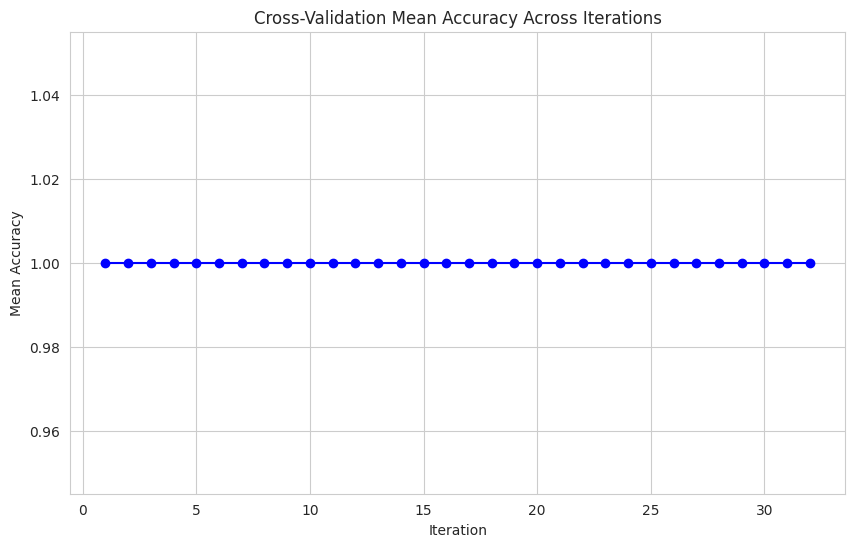

In [41]:
# Plotting
plt.figure(figsize=(10, 6))
plt.errorbar(xgboost_classification_binary_sensitivity_results['Iteration'], xgboost_classification_binary_sensitivity_results['Cross-Validation Mean Accuracy'],
             yerr=xgboost_classification_binary_sensitivity_results['Cross-Validation Std Dev'], fmt='-o', color='blue',
             ecolor='lightgray', elinewidth=3, capsize=0)
plt.title('Cross-Validation Mean Accuracy Across Iterations')
plt.xlabel('Iteration')
plt.ylabel('Mean Accuracy')
plt.grid(True)
plt.show()

#### Only Sensors

In [42]:
import warnings
import pandas as pd
from sklearn.model_selection import train_test_split, cross_val_predict, cross_val_score
import xgboost as xgb
from sklearn.metrics import confusion_matrix, classification_report

# Suppress XGBoost-related warnings
warnings.filterwarnings('ignore', category=UserWarning, module='xgboost')

# Create an empty list to store DataFrames
results_list = []

# Define features (X) and target variable (y) for classification
X = demographics[['S1', 'S2', 'S3', 'S4', 'S5', 'S6', 'S7', 'S8', 'S9', 'S10',
          'S11', 'S12', 'S13', 'S14', 'S15', 'S16', 'S17', 'S18', 'S19', 'S20',
          'S21', 'S22', 'S23', 'S24', 'S25', 'S26', 'S27', 'S28', 'S29', 'S30', 'S31', 'S32']]
y = demographics['group']  # 0 for Healthy Control, 1 for Alcoholic Liver Disease, and 2 for Parkinson's

# Specify the number of iterations
num_iterations = 32

for iteration in range(num_iterations):
    # Split the dataset into training and testing sets with a random seed
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=iteration)

    # Create and train the XGBoost classifier with specific hyperparameters
    xgb_classifier = xgb.XGBClassifier(
        objective='multi:softmax',  # Multi-class classification
        num_class=3,                # Number of classes
        random_state=42,
        n_estimators=100,           # Number of boosting rounds
        max_depth=6,                # Maximum tree depth
        learning_rate=0.1,          # Learning rate
        subsample=0.8,              # Fraction of samples used for each tree
    )

    # Perform k-fold cross-validation
    cv_scores = cross_val_score(xgb_classifier, X_train, y_train, cv=5, scoring='accuracy')

    # Make predictions on the test set
    xgb_classifier.fit(X_train, y_train)
    y_pred = xgb_classifier.predict(X_test)

    # Calculate confusion matrix and classification report
    confusion = confusion_matrix(y_test, y_pred)
    class_report = classification_report(y_test, y_pred, target_names=['Healthy Control', 'Alcoholic Liver Disease', 'Parkinson\'s'], output_dict=True)

    # Create a DataFrame for the current iteration with model information and evaluation results
    iteration_df = pd.DataFrame({
        'Iteration': [iteration + 1],
        'Cross-Validation Mean Accuracy': [cv_scores.mean()],
        'Cross-Validation Std Dev': [cv_scores.std()],
        'Confusion Matrix': [confusion],
        'Classification Report': [class_report],
    })

    # Append the DataFrame to the results list
    results_list.append(iteration_df)

# Concatenate all DataFrames in the results list
xgboost_classification_binary_sensitivity_results = pd.concat(results_list, ignore_index=True)

# Display the results DataFrame
xgboost_classification_binary_sensitivity_results.head(50)

,Iteration,Cross-Validation Mean Accuracy,Cross-Validation Std Dev,Confusion Matrix,Classification Report
0,1,0.818997,0.006699,"[[546, 23, 34], [25, 279, 36], [71, 8, 210]]",{'Healthy Control': {'precision': 0.8504672897...
1,2,0.812903,0.009647,"[[521, 16, 43], [29, 286, 28], [83, 17, 209]]",{'Healthy Control': {'precision': 0.8230647709...
2,3,0.819194,0.006092,"[[555, 25, 36], [28, 260, 37], [75, 15, 201]]",{'Healthy Control': {'precision': 0.8434650455...
3,4,0.820210,0.007498,"[[544, 17, 36], [36, 274, 31], [69, 18, 207]]",{'Healthy Control': {'precision': 0.8382126348...
4,5,0.812296,0.005222,"[[534, 18, 35], [27, 284, 23], [89, 17, 205]]",{'Healthy Control': {'precision': 0.8215384615...
5,6,0.817573,0.007573,"[[555, 18, 45], [27, 242, 28], [99, 19, 199]]",{'Healthy Control': {'precision': 0.8149779735...
6,7,0.815546,0.011854,"[[549, 18, 26], [33, 283, 26], [78, 18, 201]]",{'Healthy Control': {'precision': 0.8318181818...
7,8,0.816764,0.011412,"[[528, 21, 38], [42, 260, 22], [75, 22, 224]]",{'Healthy Control': {'precision': 0.8186046511...
8,9,0.809656,0.009608,"[[558, 18, 32], [27, 271, 21], [85, 18, 202]]",{'Healthy Control': {'precision': 0.8328358208...
9,10,0.817981,0.007138,"[[546, 20, 24], [26, 270, 19], [99, 29, 199]]",{'Healthy Control': {'precision': 0.8137108792...


In [43]:
xgboost_classification_binary_sensitivity_results.to_csv('/content/drive/MyDrive/eNose/Outputs/csv_format/xgboost_classification_binary_sensitivity_onlySensors.csv')
xgboost_classification_binary_sensitivity_results.to_html('/content/drive/MyDrive/eNose/Outputs/pdf_format/xgboost_classification_binary_sensitivity_onlySensors.pdf')

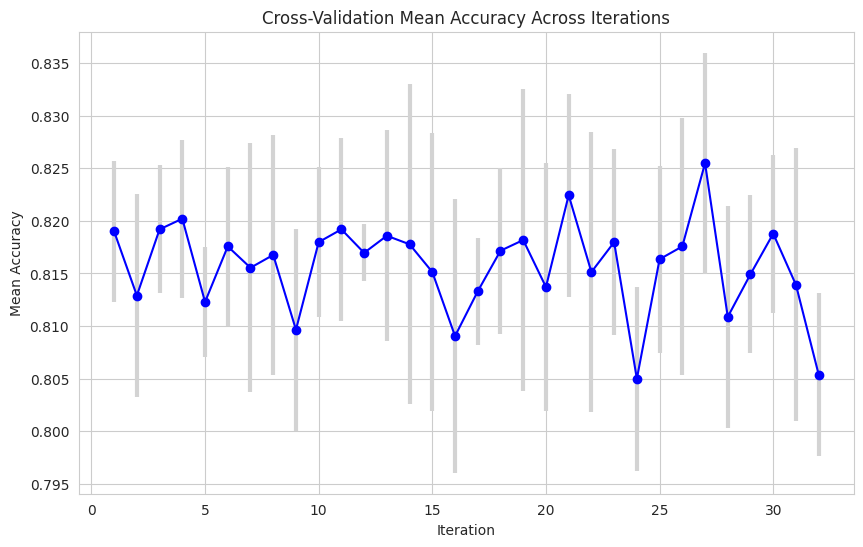

In [44]:
# Plotting
plt.figure(figsize=(10, 6))
plt.errorbar(xgboost_classification_binary_sensitivity_results['Iteration'], xgboost_classification_binary_sensitivity_results['Cross-Validation Mean Accuracy'],
             yerr=xgboost_classification_binary_sensitivity_results['Cross-Validation Std Dev'], fmt='-o', color='blue',
             ecolor='lightgray', elinewidth=3, capsize=0)
plt.title('Cross-Validation Mean Accuracy Across Iterations')
plt.xlabel('Iteration')
plt.ylabel('Mean Accuracy')
plt.grid(True)
plt.show()

### xgBoost: HC vs. ALD Accuracy

#### All Inputs

In [55]:
import warnings
import pandas as pd
from sklearn.model_selection import train_test_split
import xgboost as xgb
from sklearn.metrics import accuracy_score

# Suppress XGBoost-related warnings
warnings.filterwarnings('ignore', category=UserWarning, module='xgboost')

# Load your merged_df dataset and preprocess it
# Replace 'your_merged_df.csv' with your dataset file path

# Create an empty list to store DataFrames
results_list = []

# Define features (X) and target variable (y)
X = demographics[['Age', 'Race', 'BMI', 'LPS_Endotoxin', 'Perm_sucralose','S1', 'S2', 'S3', 'S4', 'S5', 'S6', 'S7', 'S8', 'S9', 'S10',
          'S11', 'S12', 'S13', 'S14', 'S15', 'S16', 'S17', 'S18', 'S19', 'S20',
          'S21', 'S22', 'S23', 'S24', 'S25', 'S26', 'S27', 'S28', 'S29', 'S30', 'S31', 'S32']]
y = demographics['group']  # 0 for Healthy Control, 1 for Alcoholic Liver Disease, and 2 for Parkinson's

# Filter the dataset to include only "Healthy Control" (0) and "Alcoholic Liver Disease" (1)
selected_groups = [0, 1]
X_filtered = X[y.isin(selected_groups)]
y_filtered = y[y.isin(selected_groups)]

# Specify the number of iterations
num_iterations = 32

for iteration in range(num_iterations):
    # Split the filtered dataset into training and testing sets with a random seed
    X_train, X_test, y_train, y_test = train_test_split(X_filtered, y_filtered, test_size=0.2, random_state=iteration)

    # Create and train the XGBoost classifier
    xgb_classifier = xgb.XGBClassifier(objective='binary:logistic', random_state=42)
    xgb_classifier.fit(X_train, y_train)

    # Predict disease labels on the test set
    y_pred = xgb_classifier.predict(X_test)

    # Calculate accuracy for Healthy Control (0) and Alcoholic Liver Disease (1)
    accuracy_healthy_control = accuracy_score(y_test[y_test == 0], y_pred[y_test == 0])
    accuracy_alcoholic_liver_disease = accuracy_score(y_test[y_test == 1], y_pred[y_test == 1])

    # Create a DataFrame for the current iteration
    iteration_df = pd.DataFrame({
        'Iteration': [iteration + 1],
        'Healthy Control Accuracy': [accuracy_healthy_control],
        'Alcoholic Liver Disease Accuracy': [accuracy_alcoholic_liver_disease],
    })

    # Append the DataFrame to the results list
    results_list.append(iteration_df)

# Concatenate all DataFrames in the results list
xgboost_ald_binary_accuracy_results = pd.concat(results_list, ignore_index=True)

# Display the results DataFrame
xgboost_ald_binary_accuracy_results.head(50)

,Iteration,Healthy Control Accuracy,Alcoholic Liver Disease Accuracy
0,1,1.0,1.0
1,2,1.0,1.0
2,3,1.0,1.0
3,4,1.0,1.0
4,5,1.0,1.0
5,6,1.0,1.0
6,7,1.0,1.0
7,8,1.0,1.0
8,9,1.0,1.0
9,10,1.0,1.0


In [56]:
xgboost_ald_binary_accuracy_results.to_csv('/content/drive/MyDrive/eNose/Outputs/csv_format/xgboost_ald_binary_accuracy_allInputs.csv')
xgboost_ald_binary_accuracy_results.to_html('/content/drive/MyDrive/eNose/Outputs/pdf_format/xgboost_ald_binary_accuracy_allInputs.pdf')

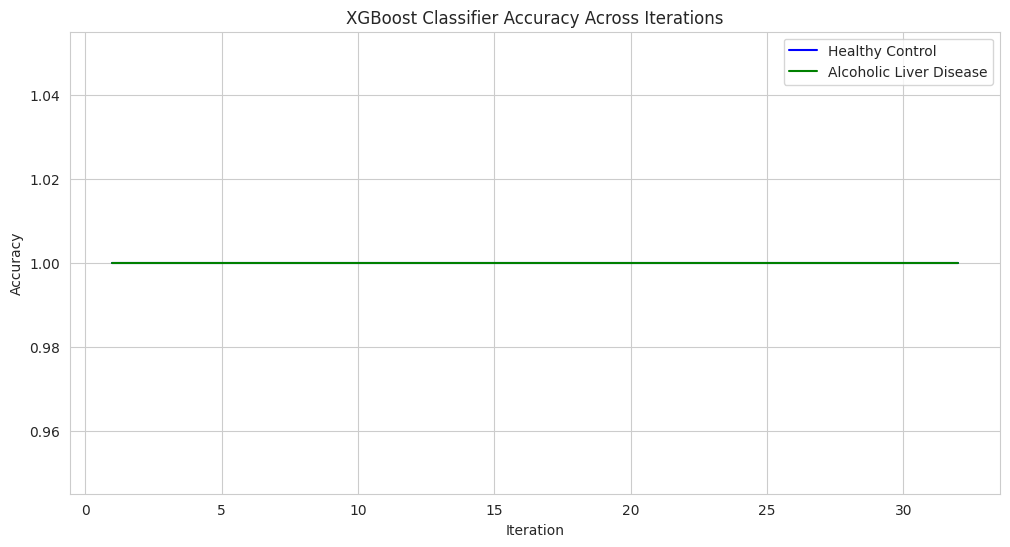

In [57]:
# Plotting the line graph
plt.figure(figsize=(12, 6))
plt.plot(xgboost_ald_binary_accuracy_results['Iteration'], xgboost_ald_binary_accuracy_results['Healthy Control Accuracy'], label='Healthy Control', color='blue')
plt.plot(xgboost_ald_binary_accuracy_results['Iteration'], xgboost_ald_binary_accuracy_results['Alcoholic Liver Disease Accuracy'], label='Alcoholic Liver Disease', color='green')
plt.title('XGBoost Classifier Accuracy Across Iterations')
plt.xlabel('Iteration')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)
plt.show()

#### Only Sensors

In [51]:
import warnings
import pandas as pd
from sklearn.model_selection import train_test_split
import xgboost as xgb
from sklearn.metrics import accuracy_score

# Suppress XGBoost-related warnings
warnings.filterwarnings('ignore', category=UserWarning, module='xgboost')

# Load your merged_df dataset and preprocess it
# Replace 'your_merged_df.csv' with your dataset file path

# Create an empty list to store DataFrames
results_list = []

# Define features (X) and target variable (y)
X = demographics[['S1', 'S2', 'S3', 'S4', 'S5', 'S6', 'S7', 'S8', 'S9', 'S10',
          'S11', 'S12', 'S13', 'S14', 'S15', 'S16', 'S17', 'S18', 'S19', 'S20',
          'S21', 'S22', 'S23', 'S24', 'S25', 'S26', 'S27', 'S28', 'S29', 'S30', 'S31', 'S32']]
y = demographics['group']  # 0 for Healthy Control, 1 for Alcoholic Liver Disease, and 2 for Parkinson's

# Filter the dataset to include only "Healthy Control" (0) and "Alcoholic Liver Disease" (1)
selected_groups = [0, 1]
X_filtered = X[y.isin(selected_groups)]
y_filtered = y[y.isin(selected_groups)]

# Specify the number of iterations
num_iterations = 32

for iteration in range(num_iterations):
    # Split the filtered dataset into training and testing sets with a random seed
    X_train, X_test, y_train, y_test = train_test_split(X_filtered, y_filtered, test_size=0.2, random_state=iteration)

    # Create and train the XGBoost classifier
    xgb_classifier = xgb.XGBClassifier(objective='binary:logistic', random_state=42)
    xgb_classifier.fit(X_train, y_train)

    # Predict disease labels on the test set
    y_pred = xgb_classifier.predict(X_test)

    # Calculate accuracy for Healthy Control (0) and Alcoholic Liver Disease (1)
    accuracy_healthy_control = accuracy_score(y_test[y_test == 0], y_pred[y_test == 0])
    accuracy_alcoholic_liver_disease = accuracy_score(y_test[y_test == 1], y_pred[y_test == 1])

    # Create a DataFrame for the current iteration
    iteration_df = pd.DataFrame({
        'Iteration': [iteration + 1],
        'Healthy Control Accuracy': [accuracy_healthy_control],
        'Alcoholic Liver Disease Accuracy': [accuracy_alcoholic_liver_disease],
    })

    # Append the DataFrame to the results list
    results_list.append(iteration_df)

# Concatenate all DataFrames in the results list
xgboost_ald_binary_accuracy_results = pd.concat(results_list, ignore_index=True)

# Display the results DataFrame
xgboost_ald_binary_accuracy_results.head(50)

,Iteration,Healthy Control Accuracy,Alcoholic Liver Disease Accuracy
0,1,0.959933,0.866261
1,2,0.940778,0.896142
2,3,0.944444,0.911932
3,4,0.964401,0.896774
4,5,0.948074,0.924471
5,6,0.972536,0.922330
6,7,0.955519,0.919003
7,8,0.947899,0.894895
8,9,0.951220,0.916933
9,10,0.958264,0.893617


In [53]:
xgboost_ald_binary_accuracy_results.to_csv('/content/drive/MyDrive/eNose/Outputs/csv_format/xgboost_ald_binary_accuracy_onlySensors.csv')
xgboost_ald_binary_accuracy_results.to_html('/content/drive/MyDrive/eNose/Outputs/pdf_format/xgboost_ald_binary_accuracy_onlySensors.pdf')

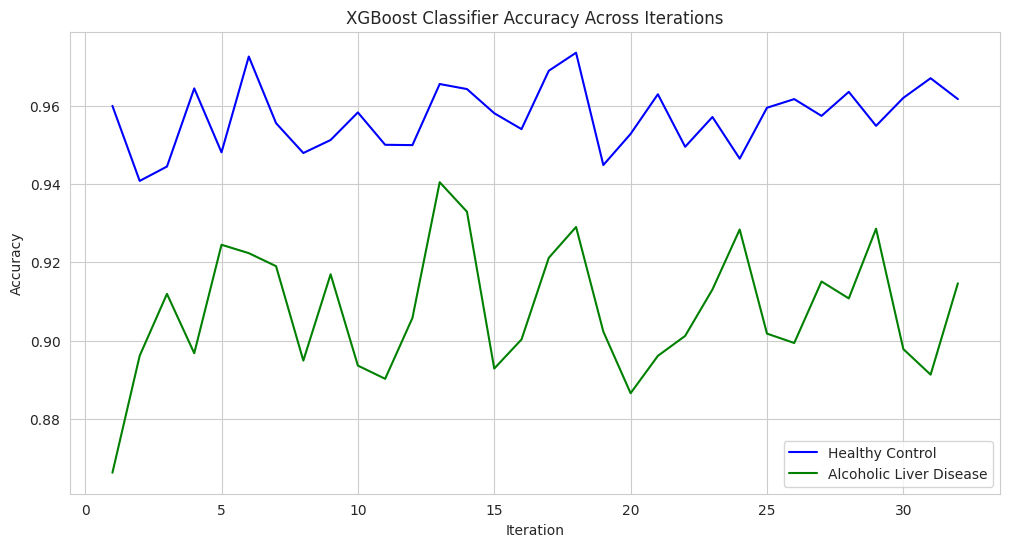

In [54]:
# Plotting the line graph
plt.figure(figsize=(12, 6))
plt.plot(xgboost_ald_binary_accuracy_results['Iteration'], xgboost_ald_binary_accuracy_results['Healthy Control Accuracy'], label='Healthy Control', color='blue')
plt.plot(xgboost_ald_binary_accuracy_results['Iteration'], xgboost_ald_binary_accuracy_results['Alcoholic Liver Disease Accuracy'], label='Alcoholic Liver Disease', color='green')
plt.title('XGBoost Classifier Accuracy Across Iterations')
plt.xlabel('Iteration')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)
plt.show()

### xgBoost: HC vs. ALD Sensitivity

#### All Inputs

In [58]:
import warnings
import pandas as pd
from sklearn.model_selection import train_test_split
import xgboost as xgb
from sklearn.metrics import accuracy_score, confusion_matrix

# Suppress XGBoost-related warnings
warnings.filterwarnings('ignore', category=UserWarning, module='xgboost')

# Load your merged_df dataset and preprocess it
# Replace 'your_merged_df.csv' with your dataset file path

# Create an empty list to store DataFrames
results_list = []

# Define features (X) and target variable (y)
X = demographics[['Age', 'Race', 'BMI', 'LPS_Endotoxin', 'Perm_sucralose','S1', 'S2', 'S3', 'S4', 'S5', 'S6', 'S7', 'S8', 'S9', 'S10',
          'S11', 'S12', 'S13', 'S14', 'S15', 'S16', 'S17', 'S18', 'S19', 'S20',
          'S21', 'S22', 'S23', 'S24', 'S25', 'S26', 'S27', 'S28', 'S29', 'S30', 'S31', 'S32']]
y = demographics['group']  # Assuming 0 for Healthy Control, 1 for Alcoholic Liver Disease, and 2 for Parkinson's

# Filter the dataset to include only "Healthy Control" (0) and "Alcoholic Liver Disease" (1)
selected_groups = [0, 1]
X_filtered = X[y.isin(selected_groups)]
y_filtered = y[y.isin(selected_groups)]

# Specify the number of iterations
num_iterations = 32

# Define a function to calculate sensitivity and specificity
def sensitivity_specificity(y_true, y_pred, positive_class=1):
    cm = confusion_matrix(y_true, y_pred)
    tn, fp, fn, tp = cm.ravel()
    if positive_class == 1:
        sensitivity = tp / (tp + fn)
        specificity = tn / (tn + fp)
    else:
        sensitivity = tn / (tn + fp)
        specificity = tp / (tp + fn)
    return sensitivity, specificity

for iteration in range(num_iterations):
    # Split the filtered dataset into training and testing sets with a random seed
    X_train, X_test, y_train, y_test = train_test_split(X_filtered, y_filtered, test_size=0.2, random_state=iteration)

    # Create and train the XGBoost classifier
    xgb_classifier = xgb.XGBClassifier(objective='binary:logistic', random_state=42)
    xgb_classifier.fit(X_train, y_train)

    # Predict disease labels on the test set
    y_pred = xgb_classifier.predict(X_test)

    # Calculate sensitivity and specificity for Healthy Control (0) and Alcoholic Liver Disease (1)
    sensitivity_healthy_control, specificity_healthy_control = sensitivity_specificity(y_test, y_pred, positive_class=0)
    sensitivity_alcoholic_liver_disease, specificity_alcoholic_liver_disease = sensitivity_specificity(y_test, y_pred, positive_class=1)

    # Create a DataFrame for the current iteration
    iteration_df = pd.DataFrame({
        'Iteration': [iteration + 1],
        'Healthy Control Sensitivity': [sensitivity_healthy_control],
        'Alcoholic Liver Disease Sensitivity': [sensitivity_alcoholic_liver_disease],
        'Healthy Control Specificity': [specificity_healthy_control],
        'Alcoholic Liver Disease Specificity': [specificity_alcoholic_liver_disease]
    })

    # Append the DataFrame to the results list
    results_list.append(iteration_df)

# Concatenate all DataFrames in the results list
xgboost_ald_binary_sensitivity_results = pd.concat(results_list, ignore_index=True)

# Display the results DataFrame
xgboost_ald_binary_sensitivity_results.head(num_iterations)


,Iteration,Healthy Control Sensitivity,Alcoholic Liver Disease Sensitivity,Healthy Control Specificity,Alcoholic Liver Disease Specificity
0,1,1.0,1.0,1.0,1.0
1,2,1.0,1.0,1.0,1.0
2,3,1.0,1.0,1.0,1.0
3,4,1.0,1.0,1.0,1.0
4,5,1.0,1.0,1.0,1.0
5,6,1.0,1.0,1.0,1.0
6,7,1.0,1.0,1.0,1.0
7,8,1.0,1.0,1.0,1.0
8,9,1.0,1.0,1.0,1.0
9,10,1.0,1.0,1.0,1.0


In [59]:
xgboost_ald_binary_sensitivity_results.to_csv('/content/drive/MyDrive/eNose/Outputs/csv_format/xgboost_ald_binary_sensitivity_allInputs.csv')
xgboost_ald_binary_sensitivity_results.to_html('/content/drive/MyDrive/eNose/Outputs/pdf_format/xgboost_ald_binary_sensitivity_allInputs.pdf')

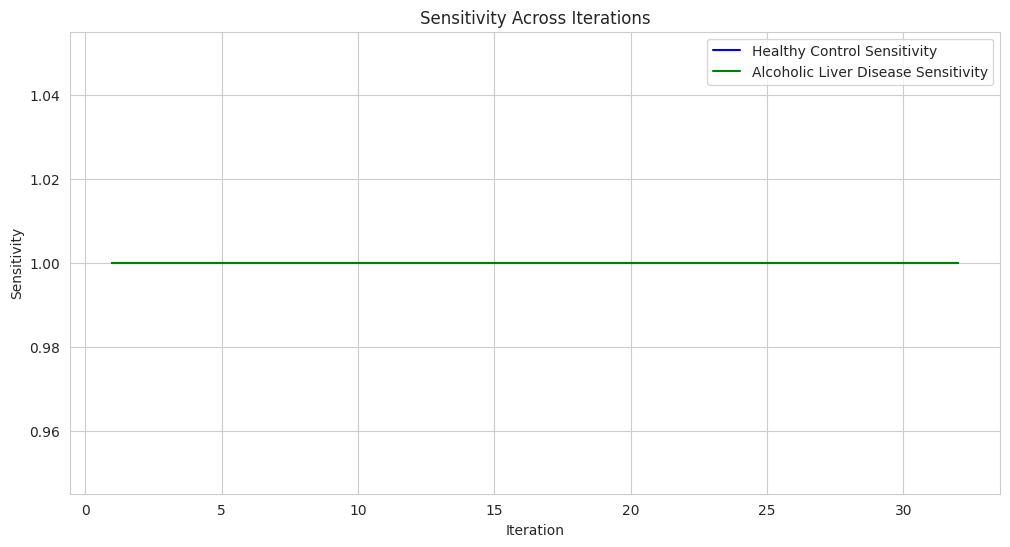

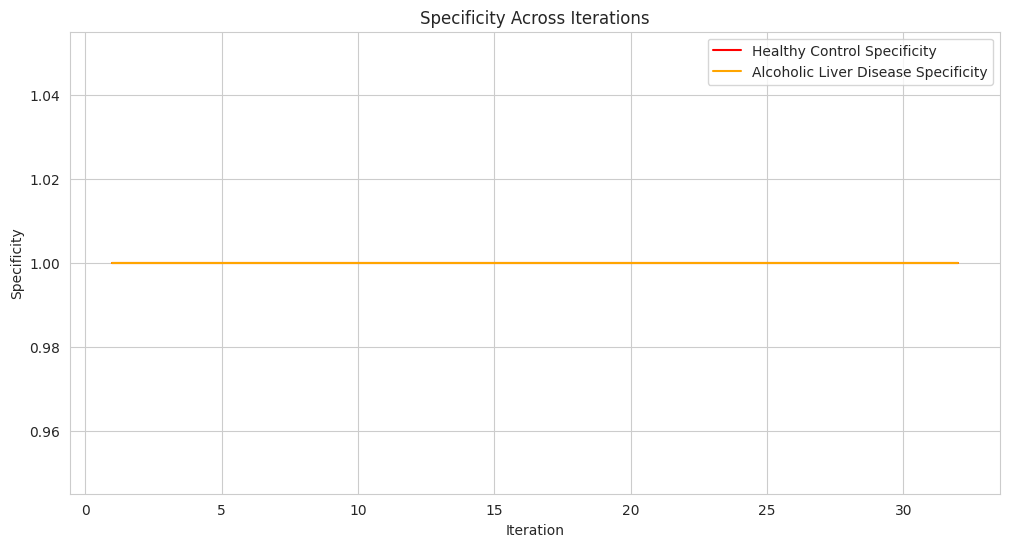

In [60]:
# Sensitivity Plot
plt.figure(figsize=(12, 6))
plt.plot(xgboost_ald_binary_sensitivity_results['Iteration'], xgboost_ald_binary_sensitivity_results['Healthy Control Sensitivity'], label='Healthy Control Sensitivity', color='blue')
plt.plot(xgboost_ald_binary_sensitivity_results['Iteration'], xgboost_ald_binary_sensitivity_results['Alcoholic Liver Disease Sensitivity'], label='Alcoholic Liver Disease Sensitivity', color='green')
plt.title('Sensitivity Across Iterations')
plt.xlabel('Iteration')
plt.ylabel('Sensitivity')
plt.legend()
plt.grid(True)
plt.show()

# Specificity Plot
plt.figure(figsize=(12, 6))
plt.plot(xgboost_ald_binary_sensitivity_results['Iteration'], xgboost_ald_binary_sensitivity_results['Healthy Control Specificity'], label='Healthy Control Specificity', color='red')
plt.plot(xgboost_ald_binary_sensitivity_results['Iteration'], xgboost_ald_binary_sensitivity_results['Alcoholic Liver Disease Specificity'], label='Alcoholic Liver Disease Specificity', color='orange')
plt.title('Specificity Across Iterations')
plt.xlabel('Iteration')
plt.ylabel('Specificity')
plt.legend()
plt.grid(True)
plt.show()

#### Only Sensors

In [61]:
import warnings
import pandas as pd
from sklearn.model_selection import train_test_split
import xgboost as xgb
from sklearn.metrics import accuracy_score, confusion_matrix

# Suppress XGBoost-related warnings
warnings.filterwarnings('ignore', category=UserWarning, module='xgboost')

# Load your merged_df dataset and preprocess it
# Replace 'your_merged_df.csv' with your dataset file path

# Create an empty list to store DataFrames
results_list = []

# Define features (X) and target variable (y)
X = demographics[['S1', 'S2', 'S3', 'S4', 'S5', 'S6', 'S7', 'S8', 'S9', 'S10',
          'S11', 'S12', 'S13', 'S14', 'S15', 'S16', 'S17', 'S18', 'S19', 'S20',
          'S21', 'S22', 'S23', 'S24', 'S25', 'S26', 'S27', 'S28', 'S29', 'S30', 'S31', 'S32']]
y = demographics['group']  # Assuming 0 for Healthy Control, 1 for Alcoholic Liver Disease, and 2 for Parkinson's

# Filter the dataset to include only "Healthy Control" (0) and "Alcoholic Liver Disease" (1)
selected_groups = [0, 1]
X_filtered = X[y.isin(selected_groups)]
y_filtered = y[y.isin(selected_groups)]

# Specify the number of iterations
num_iterations = 32

# Define a function to calculate sensitivity and specificity
def sensitivity_specificity(y_true, y_pred, positive_class=1):
    cm = confusion_matrix(y_true, y_pred)
    tn, fp, fn, tp = cm.ravel()
    if positive_class == 1:
        sensitivity = tp / (tp + fn)
        specificity = tn / (tn + fp)
    else:
        sensitivity = tn / (tn + fp)
        specificity = tp / (tp + fn)
    return sensitivity, specificity

for iteration in range(num_iterations):
    # Split the filtered dataset into training and testing sets with a random seed
    X_train, X_test, y_train, y_test = train_test_split(X_filtered, y_filtered, test_size=0.2, random_state=iteration)

    # Create and train the XGBoost classifier
    xgb_classifier = xgb.XGBClassifier(objective='binary:logistic', random_state=42)
    xgb_classifier.fit(X_train, y_train)

    # Predict disease labels on the test set
    y_pred = xgb_classifier.predict(X_test)

    # Calculate sensitivity and specificity for Healthy Control (0) and Alcoholic Liver Disease (1)
    sensitivity_healthy_control, specificity_healthy_control = sensitivity_specificity(y_test, y_pred, positive_class=0)
    sensitivity_alcoholic_liver_disease, specificity_alcoholic_liver_disease = sensitivity_specificity(y_test, y_pred, positive_class=1)

    # Create a DataFrame for the current iteration
    iteration_df = pd.DataFrame({
        'Iteration': [iteration + 1],
        'Healthy Control Sensitivity': [sensitivity_healthy_control],
        'Alcoholic Liver Disease Sensitivity': [sensitivity_alcoholic_liver_disease],
        'Healthy Control Specificity': [specificity_healthy_control],
        'Alcoholic Liver Disease Specificity': [specificity_alcoholic_liver_disease]
    })

    # Append the DataFrame to the results list
    results_list.append(iteration_df)

# Concatenate all DataFrames in the results list
xgboost_ald_binary_sensitivity_results = pd.concat(results_list, ignore_index=True)

# Display the results DataFrame
xgboost_ald_binary_sensitivity_results.head(num_iterations)


,Iteration,Healthy Control Sensitivity,Alcoholic Liver Disease Sensitivity,Healthy Control Specificity,Alcoholic Liver Disease Specificity
0,1,0.959933,0.866261,0.866261,0.959933
1,2,0.940778,0.896142,0.896142,0.940778
2,3,0.944444,0.911932,0.911932,0.944444
3,4,0.964401,0.896774,0.896774,0.964401
4,5,0.948074,0.924471,0.924471,0.948074
5,6,0.972536,0.922330,0.922330,0.972536
6,7,0.955519,0.919003,0.919003,0.955519
7,8,0.947899,0.894895,0.894895,0.947899
8,9,0.951220,0.916933,0.916933,0.951220
9,10,0.958264,0.893617,0.893617,0.958264


In [62]:
xgboost_ald_binary_sensitivity_results.to_csv('/content/drive/MyDrive/eNose/Outputs/csv_format/xgboost_ald_binary_sensitivity_onlySensors.csv')
xgboost_ald_binary_sensitivity_results.to_html('/content/drive/MyDrive/eNose/Outputs/pdf_format/xgboost_ald_binary_sensitivity_onlySensors.pdf')

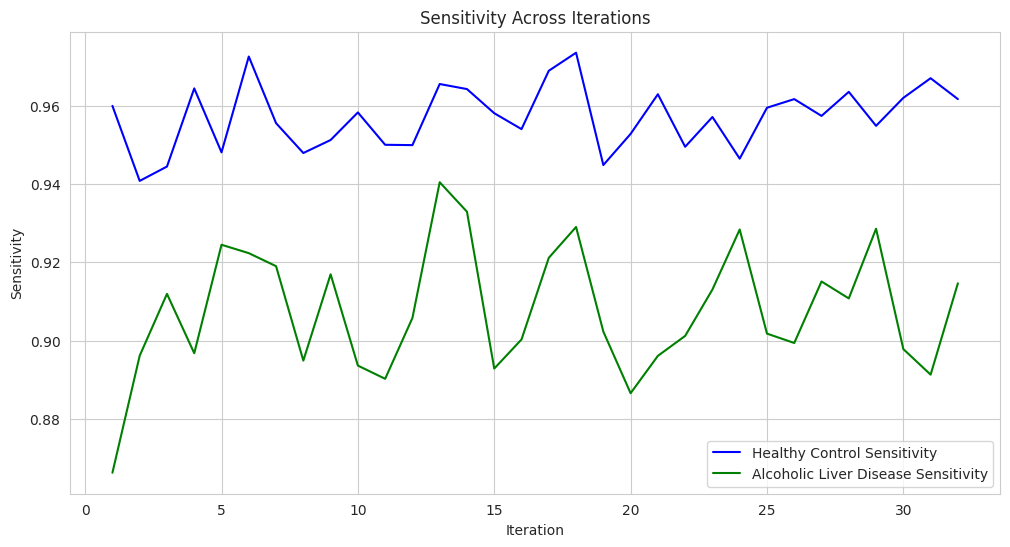

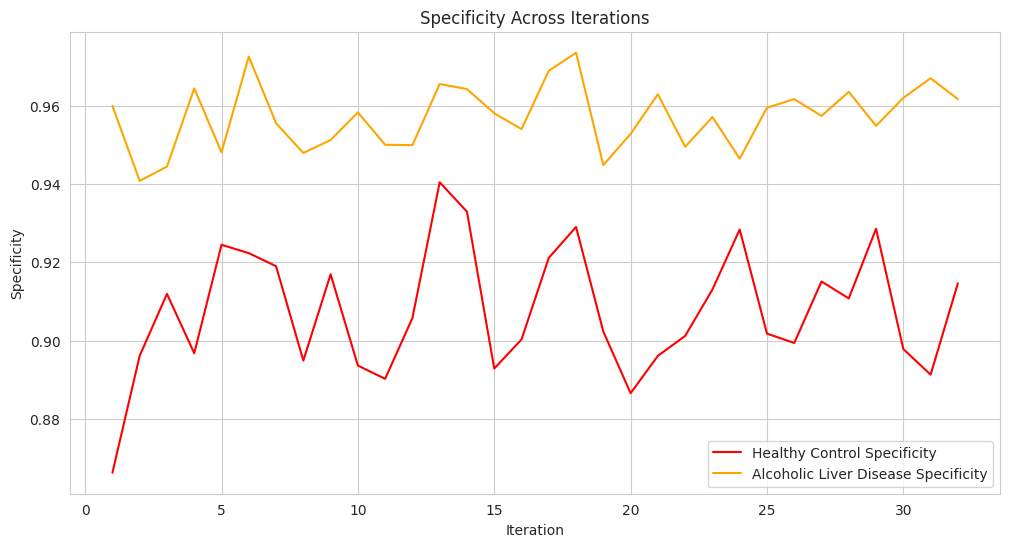

In [63]:
# Sensitivity Plot
plt.figure(figsize=(12, 6))
plt.plot(xgboost_ald_binary_sensitivity_results['Iteration'], xgboost_ald_binary_sensitivity_results['Healthy Control Sensitivity'], label='Healthy Control Sensitivity', color='blue')
plt.plot(xgboost_ald_binary_sensitivity_results['Iteration'], xgboost_ald_binary_sensitivity_results['Alcoholic Liver Disease Sensitivity'], label='Alcoholic Liver Disease Sensitivity', color='green')
plt.title('Sensitivity Across Iterations')
plt.xlabel('Iteration')
plt.ylabel('Sensitivity')
plt.legend()
plt.grid(True)
plt.show()

# Specificity Plot
plt.figure(figsize=(12, 6))
plt.plot(xgboost_ald_binary_sensitivity_results['Iteration'], xgboost_ald_binary_sensitivity_results['Healthy Control Specificity'], label='Healthy Control Specificity', color='red')
plt.plot(xgboost_ald_binary_sensitivity_results['Iteration'], xgboost_ald_binary_sensitivity_results['Alcoholic Liver Disease Specificity'], label='Alcoholic Liver Disease Specificity', color='orange')
plt.title('Specificity Across Iterations')
plt.xlabel('Iteration')
plt.ylabel('Specificity')
plt.legend()
plt.grid(True)
plt.show()

## xgBoost: Control vs. Parkinson's Accuracy

#### All Inputs

In [86]:
import warnings
import pandas as pd
from sklearn.model_selection import train_test_split
import xgboost as xgb
from sklearn.metrics import accuracy_score

# Suppress XGBoost-related warnings
warnings.filterwarnings('ignore', category=UserWarning, module='xgboost')

# Load your merged_df dataset and preprocess it
# Replace 'your_merged_df.csv' with your dataset file path

# Create an empty list to store DataFrames
results_list = []

# Filter the dataset to include only Healthy Control (group 0) and Parkinson's (group 2)
filtered_df = demographics[(demographics['group'] == 0) | (demographics['group'] == 2)]

# Define features (X) and the modified target variable (y)
X = filtered_df[['Age', 'Race', 'BMI', 'LPS_Endotoxin', 'Perm_sucralose','S1', 'S2', 'S3', 'S4', 'S5', 'S6', 'S7', 'S8', 'S9', 'S10',
          'S11', 'S12', 'S13', 'S14', 'S15', 'S16', 'S17', 'S18', 'S19', 'S20',
          'S21', 'S22', 'S23', 'S24', 'S25', 'S26', 'S27', 'S28', 'S29', 'S30', 'S31', 'S32']]
y = filtered_df['group']  # Assuming 0 for Healthy Control and 2 for Parkinson's

# Map the classes to [0, 1]
class_mapping = {0: 0, 2: 1}  # Map Parkinson's (2) to 1
y = y.map(class_mapping)

# Specify the number of iterations
num_iterations = 32

for iteration in range(num_iterations):
    # Split the dataset into training and testing sets with a random seed
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=iteration)

    # Create and train the XGBoost classifier
    xgb_classifier = xgb.XGBClassifier(objective='binary:logistic', random_state=42)
    xgb_classifier.fit(X_train, y_train)

    # Predict binary labels on the test set
    y_pred = xgb_classifier.predict(X_test)

    # Calculate accuracy for "Healthy Control" (0) and "Parkinson's" (1)
    accuracy_healthy_control = accuracy_score(y_test[y_test == 0], y_pred[y_test == 0])
    accuracy_parkinsons = accuracy_score(y_test[y_test == 1], y_pred[y_test == 1])

    # Create a DataFrame for the current iteration
    iteration_df = pd.DataFrame({
        'Iteration': [iteration + 1],
        'Healthy Control Accuracy': [accuracy_healthy_control],
        "Parkinson's Accuracy": [accuracy_parkinsons],
    })

    # Append the DataFrame to the results list
    results_list.append(iteration_df)

# Concatenate all DataFrames in the results list
xgboost_pd_binary_accuracy_results = pd.concat(results_list, ignore_index=True)

# Display the results DataFrame
xgboost_pd_binary_accuracy_results.head(num_iterations)


,Iteration,Healthy Control Accuracy,Parkinson's Accuracy
0,1,1.0,1.0
1,2,1.0,1.0
2,3,1.0,1.0
3,4,1.0,1.0
4,5,1.0,1.0
5,6,1.0,1.0
6,7,1.0,1.0
7,8,1.0,1.0
8,9,1.0,1.0
9,10,1.0,1.0


In [87]:
xgboost_pd_binary_accuracy_results.to_csv('/content/drive/MyDrive/eNose/Outputs/csv_format/xgboost_pd_binary_accuracy_allInputs.csv')
xgboost_pd_binary_accuracy_results.to_html('/content/drive/MyDrive/eNose/Outputs/pdf_format/xgboost_pd_binary_accuracy_allInputs.pdf')

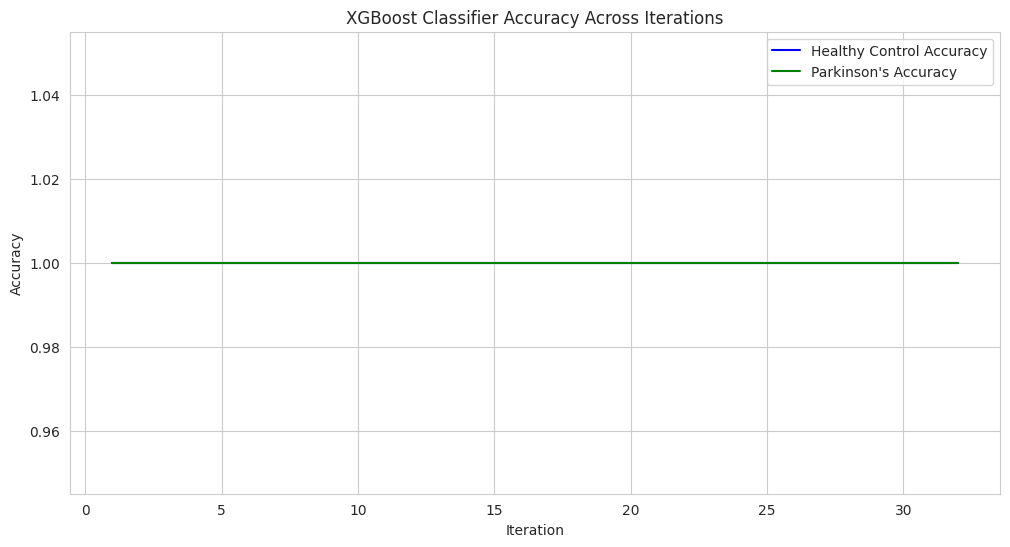

In [88]:
# Plotting the line graph
plt.figure(figsize=(12, 6))
plt.plot(xgboost_pd_binary_accuracy_results['Iteration'], xgboost_pd_binary_accuracy_results['Healthy Control Accuracy'], label='Healthy Control Accuracy', color='blue')
plt.plot(xgboost_pd_binary_accuracy_results['Iteration'], xgboost_pd_binary_accuracy_results["Parkinson's Accuracy"], label="Parkinson's Accuracy", color='green')
plt.title('XGBoost Classifier Accuracy Across Iterations')
plt.xlabel('Iteration')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)
plt.show()

#### Only Sensors

In [89]:
import warnings
import pandas as pd
from sklearn.model_selection import train_test_split
import xgboost as xgb
from sklearn.metrics import accuracy_score

# Suppress XGBoost-related warnings
warnings.filterwarnings('ignore', category=UserWarning, module='xgboost')

# Load your merged_df dataset and preprocess it
# Replace 'your_merged_df.csv' with your dataset file path

# Create an empty list to store DataFrames
results_list = []

# Filter the dataset to include only Healthy Control (group 0) and Parkinson's (group 2)
filtered_df = demographics[(demographics['group'] == 0) | (demographics['group'] == 2)]

# Define features (X) and the modified target variable (y)
X = filtered_df[['S1', 'S2', 'S3', 'S4', 'S5', 'S6', 'S7', 'S8', 'S9', 'S10',
          'S11', 'S12', 'S13', 'S14', 'S15', 'S16', 'S17', 'S18', 'S19', 'S20',
          'S21', 'S22', 'S23', 'S24', 'S25', 'S26', 'S27', 'S28', 'S29', 'S30', 'S31', 'S32']]
y = filtered_df['group']  # Assuming 0 for Healthy Control and 2 for Parkinson's

# Map the classes to [0, 1]
class_mapping = {0: 0, 2: 1}  # Map Parkinson's (2) to 1
y = y.map(class_mapping)

# Specify the number of iterations
num_iterations = 32

for iteration in range(num_iterations):
    # Split the dataset into training and testing sets with a random seed
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=iteration)

    # Create and train the XGBoost classifier
    xgb_classifier = xgb.XGBClassifier(objective='binary:logistic', random_state=42)
    xgb_classifier.fit(X_train, y_train)

    # Predict binary labels on the test set
    y_pred = xgb_classifier.predict(X_test)

    # Calculate accuracy for "Healthy Control" (0) and "Parkinson's" (1)
    accuracy_healthy_control = accuracy_score(y_test[y_test == 0], y_pred[y_test == 0])
    accuracy_parkinsons = accuracy_score(y_test[y_test == 1], y_pred[y_test == 1])

    # Create a DataFrame for the current iteration
    iteration_df = pd.DataFrame({
        'Iteration': [iteration + 1],
        'Healthy Control Accuracy': [accuracy_healthy_control],
        "Parkinson's Accuracy": [accuracy_parkinsons],
    })

    # Append the DataFrame to the results list
    results_list.append(iteration_df)

# Concatenate all DataFrames in the results list
xgboost_pd_binary_accuracy_results = pd.concat(results_list, ignore_index=True)

# Display the results DataFrame
xgboost_pd_binary_accuracy_results.head(num_iterations)

,Iteration,Healthy Control Accuracy,Parkinson's Accuracy
0,1,0.906667,0.822368
1,2,0.905724,0.822581
2,3,0.890344,0.849829
3,4,0.932998,0.846906
4,5,0.922442,0.802013
5,6,0.918333,0.779605
6,7,0.913115,0.792517
7,8,0.942470,0.741214
8,9,0.900974,0.847222
9,10,0.912480,0.815331


In [90]:
xgboost_pd_binary_accuracy_results.to_csv('/content/drive/MyDrive/eNose/Outputs/csv_format/xgboost_pd_binary_accuracy_onlySensors.csv')
xgboost_pd_binary_accuracy_results.to_html('/content/drive/MyDrive/eNose/Outputs/pdf_format/xgboost_pd_binary_accuracy_onlySensors.pdf')

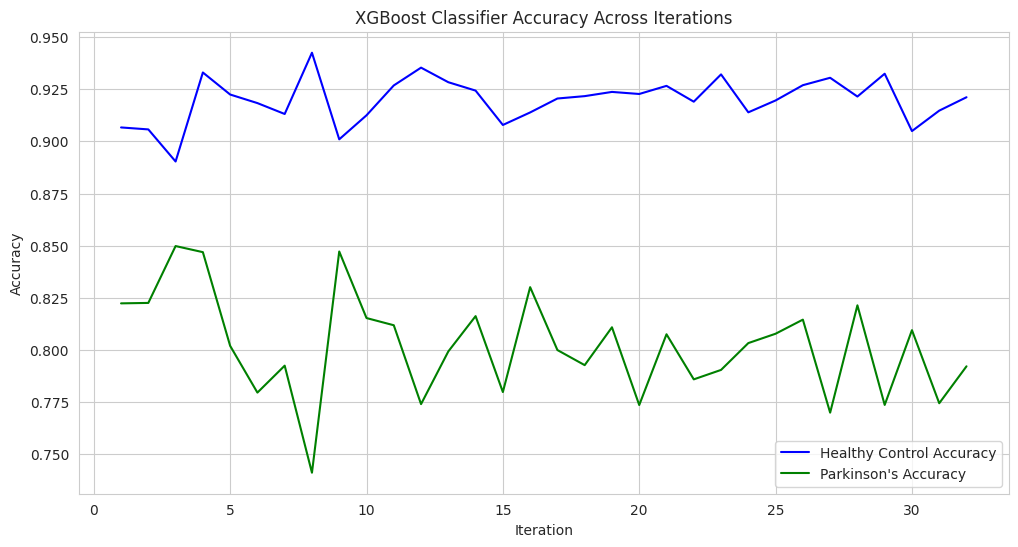

In [91]:
# Ensure to use the exact column name from your DataFrame
plt.figure(figsize=(12, 6))
plt.plot(xgboost_pd_binary_accuracy_results['Iteration'], xgboost_pd_binary_accuracy_results['Healthy Control Accuracy'], label='Healthy Control Accuracy', color='blue')
plt.plot(xgboost_pd_binary_accuracy_results['Iteration'], xgboost_pd_binary_accuracy_results["Parkinson's Accuracy"], label="Parkinson's Accuracy", color='green')
plt.title('XGBoost Classifier Accuracy Across Iterations')
plt.xlabel('Iteration')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)
plt.show()

## xgBoost: Control vs. Parkinson's Sensitivity

### All Inputs

In [92]:
import warnings
import pandas as pd
from sklearn.model_selection import train_test_split
import xgboost as xgb
from sklearn.metrics import accuracy_score, confusion_matrix

# Suppress XGBoost-related warnings
warnings.filterwarnings('ignore', category=UserWarning, module='xgboost')

# Load your merged_df dataset and preprocess it (as you've done)

# Create an empty list to store DataFrames
results_list = []

# Filter the dataset to include only Healthy Control (group 0) and Parkinson's (group 2)
filtered_df = demographics[(demographics['group'] == 0) | (demographics['group'] == 2)]

# Define features (X) and the modified target variable (y)
X = filtered_df[['Age', 'Race', 'BMI', 'LPS_Endotoxin', 'Perm_sucralose','S1', 'S2', 'S3', 'S4', 'S5', 'S6', 'S7', 'S8', 'S9', 'S10',
          'S11', 'S12', 'S13', 'S14', 'S15', 'S16', 'S17', 'S18', 'S19', 'S20',
          'S21', 'S22', 'S23', 'S24', 'S25', 'S26', 'S27', 'S28', 'S29', 'S30', 'S31', 'S32']]
y = filtered_df['group']  # Assuming 0 for Healthy Control and 2 for Parkinson's

# Map the classes to [0, 1]
class_mapping = {0: 0, 2: 1}  # Map Parkinson's (2) to 1
y = y.map(class_mapping)

# Specify the number of iterations
num_iterations = 20

for iteration in range(num_iterations):
    # Split the dataset into training and testing sets with a random seed
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=iteration)

    # Create and train the XGBoost classifier
    xgb_classifier = xgb.XGBClassifier(objective='binary:logistic', random_state=42)
    xgb_classifier.fit(X_train, y_train)

    # Predict binary labels on the test set
    y_pred = xgb_classifier.predict(X_test)

    # Calculate the confusion matrix
    cm = confusion_matrix(y_test, y_pred)

    # Calculate sensitivity (True Positive Rate) for "Parkinson's" (1)
    sensitivity_parkinsons = cm[1, 1] / (cm[1, 0] + cm[1, 1])

    # Calculate specificity (True Negative Rate) for "Healthy Control" (0)
    specificity_healthy_control = cm[0, 0] / (cm[0, 0] + cm[0, 1])

    # Create a DataFrame for the current iteration
    iteration_df = pd.DataFrame({
        'Iteration': [iteration + 1],
        "Parkinson's Sensitivity": [sensitivity_parkinsons],
        'Healthy Control Specificity': [specificity_healthy_control],
    })

    # Append the DataFrame to the results list
    results_list.append(iteration_df)

# Concatenate all DataFrames in the results list
xgboost_pd_binary_sensitivity_results = pd.concat(results_list, ignore_index=True)

# Display the results DataFrame
xgboost_pd_binary_sensitivity_results.head(num_iterations)

,Iteration,Parkinson's Sensitivity,Healthy Control Specificity
0,1,1.0,1.0
1,2,1.0,1.0
2,3,1.0,1.0
3,4,1.0,1.0
4,5,1.0,1.0
5,6,1.0,1.0
6,7,1.0,1.0
7,8,1.0,1.0
8,9,1.0,1.0
9,10,1.0,1.0


In [93]:
xgboost_pd_binary_sensitivity_results.to_csv('/content/drive/MyDrive/eNose/Outputs/csv_format/xgboost_pd_binary_sensitivity_allInputs.csv')
xgboost_pd_binary_sensitivity_results.to_html('/content/drive/MyDrive/eNose/Outputs/pdf_format/xgboost_pd_binary_sensitivity_allInputs.pdf')

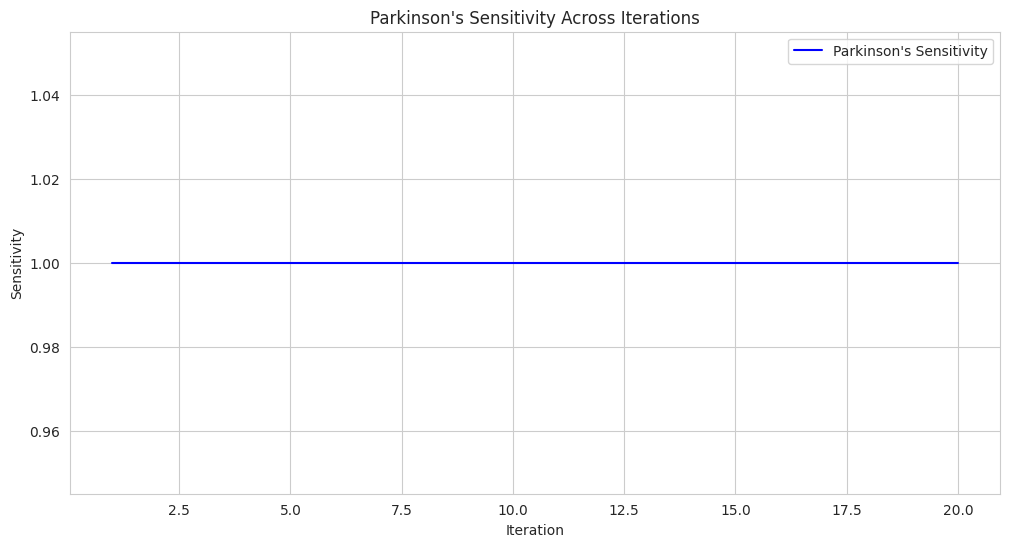

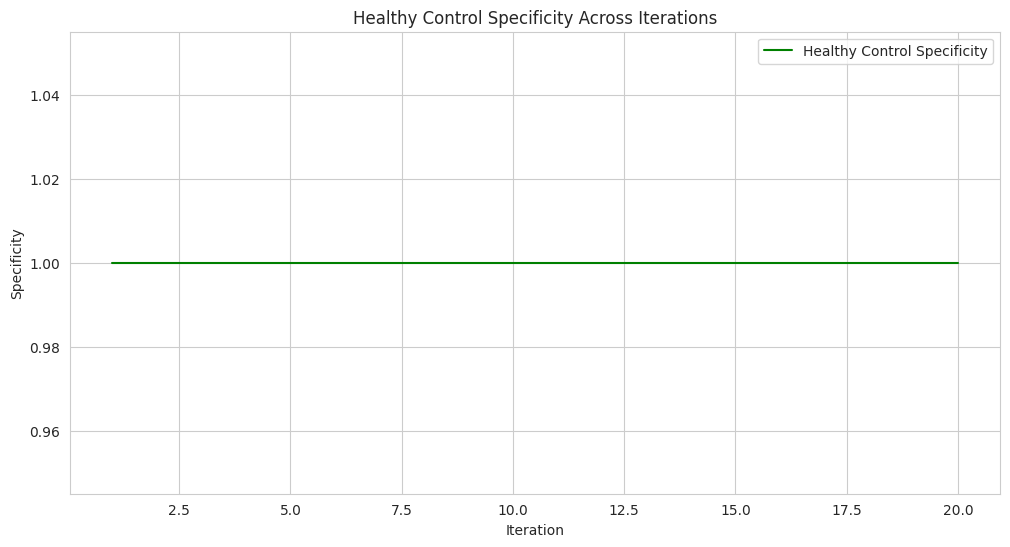

In [94]:
# Plotting Parkinson's Sensitivity
plt.figure(figsize=(12, 6))
plt.plot(xgboost_pd_binary_sensitivity_results['Iteration'], xgboost_pd_binary_sensitivity_results["Parkinson's Sensitivity"], label="Parkinson's Sensitivity", color='blue')
plt.title("Parkinson's Sensitivity Across Iterations")
plt.xlabel('Iteration')
plt.ylabel('Sensitivity')
plt.legend()
plt.grid(True)
plt.show()

# Plotting Healthy Control Specificity
plt.figure(figsize=(12, 6))
plt.plot(xgboost_pd_binary_sensitivity_results['Iteration'], xgboost_pd_binary_sensitivity_results['Healthy Control Specificity'], label='Healthy Control Specificity', color='green')
plt.title('Healthy Control Specificity Across Iterations')
plt.xlabel('Iteration')
plt.ylabel('Specificity')
plt.legend()
plt.grid(True)
plt.show()

### Only Sensors

In [95]:
import warnings
import pandas as pd
from sklearn.model_selection import train_test_split
import xgboost as xgb
from sklearn.metrics import accuracy_score, confusion_matrix

# Suppress XGBoost-related warnings
warnings.filterwarnings('ignore', category=UserWarning, module='xgboost')

# Load your merged_df dataset and preprocess it (as you've done)

# Create an empty list to store DataFrames
results_list = []

# Filter the dataset to include only Healthy Control (group 0) and Parkinson's (group 2)
filtered_df = demographics[(demographics['group'] == 0) | (demographics['group'] == 2)]

# Define features (X) and the modified target variable (y)
X = filtered_df[['S1', 'S2', 'S3', 'S4', 'S5', 'S6', 'S7', 'S8', 'S9', 'S10',
              'S11', 'S12', 'S13', 'S14', 'S15', 'S16', 'S17', 'S18', 'S19', 'S20',
              'S21', 'S22', 'S23', 'S24', 'S25', 'S26', 'S27', 'S28', 'S29', 'S30', 'S31', 'S32']]
y = filtered_df['group']  # Assuming 0 for Healthy Control and 2 for Parkinson's

# Map the classes to [0, 1]
class_mapping = {0: 0, 2: 1}  # Map Parkinson's (2) to 1
y = y.map(class_mapping)

# Specify the number of iterations
num_iterations = 20

for iteration in range(num_iterations):
    # Split the dataset into training and testing sets with a random seed
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=iteration)

    # Create and train the XGBoost classifier
    xgb_classifier = xgb.XGBClassifier(objective='binary:logistic', random_state=42)
    xgb_classifier.fit(X_train, y_train)

    # Predict binary labels on the test set
    y_pred = xgb_classifier.predict(X_test)

    # Calculate the confusion matrix
    cm = confusion_matrix(y_test, y_pred)

    # Calculate sensitivity (True Positive Rate) for "Parkinson's" (1)
    sensitivity_parkinsons = cm[1, 1] / (cm[1, 0] + cm[1, 1])

    # Calculate specificity (True Negative Rate) for "Healthy Control" (0)
    specificity_healthy_control = cm[0, 0] / (cm[0, 0] + cm[0, 1])

    # Create a DataFrame for the current iteration
    iteration_df = pd.DataFrame({
        'Iteration': [iteration + 1],
        'Parkinson\'s Sensitivity': [sensitivity_parkinsons],
        'Healthy Control Specificity': [specificity_healthy_control],
    })

    # Append the DataFrame to the results list
    results_list.append(iteration_df)

# Concatenate all DataFrames in the results list
xgboost_pd_binary_sensitivity_results = pd.concat(results_list, ignore_index=True)

# Display the results DataFrame
xgboost_pd_binary_sensitivity_results.head(num_iterations)

,Iteration,Parkinson's Sensitivity,Healthy Control Specificity
0,1,0.822368,0.906667
1,2,0.822581,0.905724
2,3,0.849829,0.890344
3,4,0.846906,0.932998
4,5,0.802013,0.922442
5,6,0.779605,0.918333
6,7,0.792517,0.913115
7,8,0.741214,0.942470
8,9,0.847222,0.900974
9,10,0.815331,0.912480


In [96]:
xgboost_pd_binary_sensitivity_results.to_csv('/content/drive/MyDrive/eNose/Outputs/csv_format/xgboost_pd_binary_sensitivity_onlySensors.csv')
xgboost_pd_binary_sensitivity_results.to_html('/content/drive/MyDrive/eNose/Outputs/pdf_format/xgboost_pd_binary_sensitivity_onlySensors.pdf')

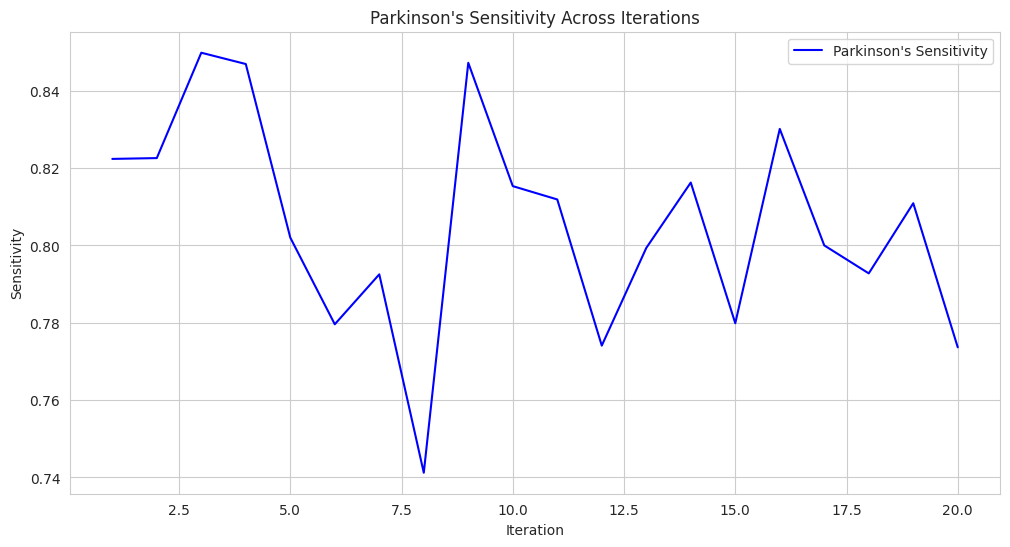

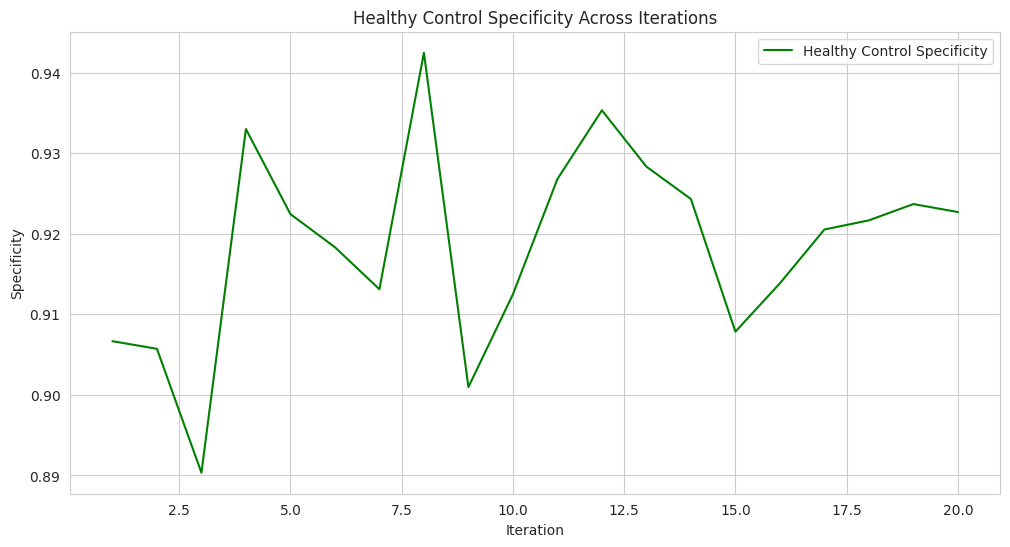

In [97]:
# Plotting Parkinson's Sensitivity
plt.figure(figsize=(12, 6))
plt.plot(xgboost_pd_binary_sensitivity_results['Iteration'], xgboost_pd_binary_sensitivity_results["Parkinson's Sensitivity"], label="Parkinson's Sensitivity", color='blue')
plt.title("Parkinson's Sensitivity Across Iterations")
plt.xlabel('Iteration')
plt.ylabel('Sensitivity')
plt.legend()
plt.grid(True)
plt.show()

# Plotting Healthy Control Specificity
plt.figure(figsize=(12, 6))
plt.plot(xgboost_pd_binary_sensitivity_results['Iteration'], xgboost_pd_binary_sensitivity_results['Healthy Control Specificity'], label='Healthy Control Specificity', color='green')
plt.title('Healthy Control Specificity Across Iterations')
plt.xlabel('Iteration')
plt.ylabel('Specificity')
plt.legend()
plt.grid(True)
plt.show()

# Individual Inputs Influence

## All Inputs

In [104]:
import pandas as pd
from sklearn.model_selection import train_test_split
from xgboost import XGBClassifier
import matplotlib.pyplot as plt

# Step 1: Prepare Data
selected_features = ['Age', 'Race', 'BMI', 'LPS_Endotoxin', 'Perm_sucralose','S1', 'S2', 'S3', 'S4', 'S5', 'S6', 'S7', 'S8', 'S9', 'S10',
          'S11', 'S12', 'S13', 'S14', 'S15', 'S16', 'S17', 'S18', 'S19', 'S20',
          'S21', 'S22', 'S23', 'S24', 'S25', 'S26', 'S27', 'S28', 'S29', 'S30', 'S31', 'S32']
X = demographics[selected_features].fillna(0)  # Fill NA values if any
y = demographics['group']

# Step 2: Split Data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Step 3: Train XGBoost Model
model = XGBClassifier()
model.fit(X_train, y_train)

# Step 4: Feature Importance
feature_importance = model.feature_importances_
feature_importance_df = pd.DataFrame({'Feature': selected_features, 'Importance': feature_importance})

# Step 5: Determine Viability
threshold = 0.05
feature_importance_df['Viable'] = feature_importance_df['Importance'] > threshold

# Display the DataFrame
feature_importance_df.head(50)

,Feature,Importance,Viable
0,Age,0.074044,True
1,Race,0.000000,False
2,BMI,0.008794,False
3,LPS_Endotoxin,0.250501,True
4,Perm_sucralose,0.607625,True
5,S1,0.052449,True
6,S2,0.000307,False
7,S3,0.000035,False
8,S4,0.000421,False
9,S5,0.000000,False


In [106]:
feature_importance_df.to_csv('/content/drive/MyDrive/eNose/Outputs/csv_format/xgboost_pd_binary_sensitivity_allInputs.csv')
feature_importance_df.to_html('/content/drive/MyDrive/eNose/Outputs/pdf_format/xgboost_pd_binary_sensitivity_allInputs.pdf')

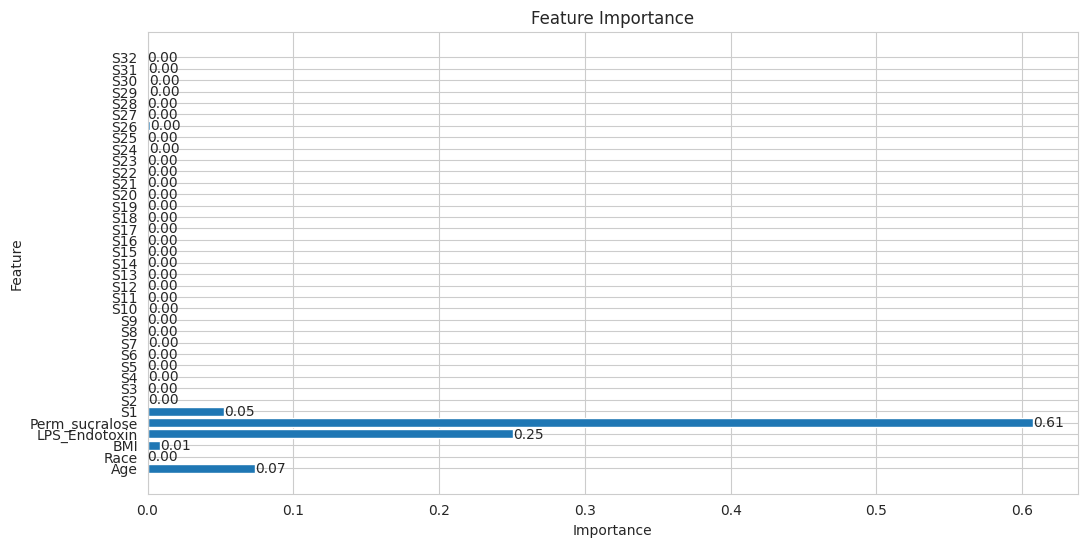

In [107]:
plt.figure(figsize=(12, 6))
bars = plt.barh(feature_importance_df['Feature'], feature_importance_df['Importance'])

# Adding labels to the bars
for bar in bars:
    plt.text(bar.get_width(), bar.get_y() + bar.get_height() / 2,
             f'{bar.get_width():.2f}',
             va='center', ha='left')

plt.xlabel('Importance')
plt.ylabel('Feature')
plt.title('Feature Importance')
plt.show()

### Best Combination of Features


0.90 - 1.00: Excellent
Scores above 0.90 are typically considered excellent in many applications, but be cautious of overfitting, especially with smaller datasets.

0.80 - 0.90: Good
This range is often regarded as good. It indicates that the model is learning well, though there may be room for improvement.

0.70 - 0.80: Fair
This range is seen as fair. The model is learning but not performing optimally. There might be issues related to data quality, feature selection, or model choice.

0.60 - 0.70: Poor
Scores in this range are often considered poor. They indicate that the model isn't learning enough from the data.
Below 0.60: Fail
Scores below 0.60 typically suggest that the model is not performing well, possibly doing little better than random guessing in some cases.


In [109]:
dfiltered_features = feature_importance_df[feature_importance_df['Viable'] == True]

In [113]:
filtered_features

,Feature,Importance,Viable
0,Age,0.074044,True
3,LPS_Endotoxin,0.250501,True
4,Perm_sucralose,0.607625,True
5,S1,0.052449,True


In [ ]:
import pandas as pd
from itertools import combinations
from sklearn.model_selection import cross_val_score
from xgboost import XGBClassifier
from joblib import Parallel, delayed

# Step 1: Prepare Data
X = demographics[filtered_features]  # Features
y = demographics['group']  # Target variable

# Step 3: Iterate through all possible combinations of features
def evaluate_feature_combination(feature_combination):
    X_subset = X[list(feature_combination)]
    scores = cross_val_score(model, X_subset, y, cv=5)
    mean_score = scores.mean()
    return mean_score, feature_combination

# Step 4: Initialize dictionary to store best combinations
best_combinations = {}

# Define the unique diagnoses
unique_diagnoses = [1, 0, 2]

# Iterate over each unique diagnosis
for diagnosis in unique_diagnoses:
    y_diagnosis = demographics[demographics['Group_Diagnosis'] == diagnosis]['Group_Diagnosis']
    best_score = -1
    best_feature_combination = None

    results = Parallel(n_jobs=-1)(delayed(evaluate_feature_combination)(feature_combination)
                                  for r in range(1, len(filtered_features) + 1)
                                  for feature_combination in combinations(selected_features, r))

    for mean_score, feature_combination in results:
        if mean_score > best_score:
            best_score = mean_score
            best_feature_combination = feature_combination

    best_combinations[diagnosis] = (best_feature_combination, best_score)

# Step 5: Print Best Combination for Each Diagnosis
for diagnosis in best_combinations:
    print(f"Diagnosis: {diagnosis}")
    print("Best combination of features:", best_combinations[diagnosis][0])
    print("Best cross-validation score:", best_combinations[diagnosis][1])
    print()

In [ ]:
best_combinations.to_csv('/content/drive/MyDrive/eNose/Outputs/csv_format/best_combinations_allInputs.csv')
best_combinations.to_html('/content/drive/MyDrive/eNose/Outputs/pdf_format/best_combinations_allInputs.pdf')